Installing relevent libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
import traceback

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# TensorFlow/Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification, pipeline, AutoTokenizer

# Statsmodels & Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# XGBoost and LightGBM
from xgboost import XGBRegressor
import lightgbm as lgb

# SHAP
import shap

# NLTK and TextBlob
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import nltk

# Yahoo Finance
import yfinance as yf



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


# Project


#### Project Overview
This project predicts Bitcoin's next-day price percentage change by integrating sentiment analysis of X posts with historical price data, using deep learning models (LSTM and GRU). It fulfills the requirements of the MSc in IT for Business Data Analytics Capstone Project at the International Business School, The University of Buckingham.

#### Objectives
- Collect and preprocess X posts and cryptocurrency price data.\n",
- Perform sentiment analysis using a BERT-based model.\n",
- Conduct exploratory data analysis (EDA) to identify trends and correlations.\n",
- Implement and optimize LSTM and GRU models.\n",
- Evaluate model performance and provide business insights.\n",

#### Dependencies
Run the following cell to import all required libraries. Ensure `requirements.txt` is installed as per the README

# Dataset Cleaning Tweets


#### Data Collection

We collect X posts related to Bitcoin from Feb 2021 to Jan 2023, containing 224,821 tweets. Only the `date` and `text` columns are retained for analysis.

**Note**: Update the file path below to your local copy of `Bitcoin_tweets.csv`.


In [3]:
# Define columns you want to keep
columns_to_keep = ['date', 'text']

# Create an empty CSV to save the cleaned version
output_file = 'bitcoin_tweets_date_text.csv'
first_chunk = True

for chunk in pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets.csv', chunksize=100000, engine='python'):  
    chunk = chunk[columns_to_keep]
    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

In [4]:
df_raw = pd.read_csv("/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/bitcoin_tweets_date_text.csv")

In [5]:
df_raw.head()

date                                               text
0  2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...
1  2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will do a "...
2  2021-02-10 23:54:48  Guys evening, I have read this article about B...
3  2021-02-10 23:54:33  $BTC A big chance in a billion! Price: \487264...
4  2021-02-10 23:54:06  This network is secured by 9 508 nodes as of t...

#### Tweet Cleaning

We clean the tweet data by:
- Sampling 5% of the data to manage computational constraints.
- Removing noise (hashtags, URLs, mentions) using vectorized operations for efficiency.

In [6]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac= 0.05, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
tweets_clean_file = '/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv'
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_43881/3110960639.py:8: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
100%|██████████| 234655/234655 [08:34<00:00, 455.85it/s] 


In [7]:
df_clean = pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv')

In [8]:
#Displaying the first few rows of the data
df_clean.head()

index                 date  \
0  3885516  2022-07-15 13:47:46   
1   984434  2021-08-16 05:15:11   
2   207647  2021-06-21 21:42:06   
3  2529662  2022-03-16 16:05:00   
4   552292  2021-07-18 14:28:49   

                                                text  
0  Aeron (ARNX) went up 11.6 percent in the last ...  
1  Bitcoin looking bullish👍\n\nA Golden Cross on ...  
2  I have made 23X gain from doge. Now how many X...  
3  NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...  
4  This is definitely going to be HUGE!  as the t...

In [9]:
df = df_clean.copy()
df = df[['text']] 
df.columns = ['tweets']
df.head()

tweets
0  Aeron (ARNX) went up 11.6 percent in the last ...
1  Bitcoin looking bullish👍\n\nA Golden Cross on ...
2  I have made 23X gain from doge. Now how many X...
3  NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4  This is definitely going to be HUGE!  as the t...

In [10]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [12]:
# Clean missing tweets
df['tweets'] = df['tweets'].fillna("")

# Clean tweets
df['cleaned_tweets'] = df['tweets'].apply(cleaning)

# Set date properly
df['date'] = df_clean['date']   # WARNING: make sure df_clean has no weird data
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Drop bad rows where date_clean is NaT
df = df.dropna(subset=['date_clean'])

# Drop old 'date' column
df.drop(columns='date', inplace=True)

# Show result
df.head()


tweets  \
0  Aeron (ARNX) went up 11.6 percent in the last ...   
1  Bitcoin looking bullish👍\n\nA Golden Cross on ...   
2  I have made 23X gain from doge. Now how many X...   
3  NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...   
4  This is definitely going to be HUGE!  as the t...   

                                      cleaned_tweets  date_clean  
0  Aeron ARNX went percent last minute rgEAV yjP ...  2022-07-15  
1  Bitcoin looking bullish A Golden Cross daily t...  2021-08-16  
2  I made X gain doge Now many XXX f cked Bitcoin...  2021-06-21  
3  NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...  2022-03-16  
4  This definitely going HUGE team inspiration in...  2021-07-18

We can now see the tweets and data cleaned which are now ready for the sentiment analysis.

### EDA-Tweets

In [13]:
# Create daily tweet aggregation with cleaned data
daily_tweets = df.groupby('date_clean').size().reset_index(name='tweet_count')

# Print daily tweet statistics
print("Daily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Daily tweet statistics:
count     222.000000
mean     1056.211712
std       758.638716
min         6.000000
25%       322.750000
50%       946.000000
75%      1595.500000
max      3492.000000
Name: tweet_count, dtype: float64


In [14]:
print(df['date_clean'].min())
print(df['date_clean'].max())


2021-02-05
2023-01-09


# Data Bitcoin Prices

We get the bitcoin prices from the dates 2021-02-05 till 2023-01-09

In [15]:
# Fetch historical Bitcoin prices
def get_btc_prices(start_date='2021-02-05', end_date='2023-01-09'):
    btc = yf.Ticker("BTC-USD")
    df = btc.history(start=start_date, end=end_date)
    return df[['Close', 'Volume']].rename(columns={'Close': 'price'})

# Sentiment Analysis

CryptoBERT is a pre-trained NLP model to analyse the language and sentiments of cryptocurrency-related social media posts and messages. It was built by further training the vinai's bertweet-base language model on the cryptocurrency domain, using a corpus of over 3.2M unique cryptocurrency-related social media posts.

The model was trained on the following labels: "Bearish" : 0, "Neutral": 1, "Bullish": 2



loads the model and tokenizer using the AutoTokenizer and AutoModelForSequenceClassification classes.

In [16]:
tokenizer = AutoTokenizer.from_pretrained('ElKulako/cryptobert')
model = AutoModelForSequenceClassification.from_pretrained('ElKulako/cryptobert')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def batch_sentiment(texts, batch_size=32):
    sentiments = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = sentiment_pipeline(batch)
        sentiments.extend(results)
    return sentiments

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now we apply the sentiment analysis

In [17]:
# Apply sentiment analysis
sentiments = batch_sentiment(df['cleaned_tweets'].tolist())
df['sentiment'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

In [18]:
# Ensure 'date_clean' is in datetime format
df['date_clean'] = pd.to_datetime(df['date_clean'])

# Sort the DataFrame by date
df = df.sort_values(by='date_clean').reset_index(drop=True)

# Preview the first few rows
df.head()


tweets  \
0  Bitcoin BTC current price (GBP): £27,618\nLike...   
1  Tune in to : The Bitcoin Revolution Isn't Comi...   
2  Bitcoin BTC Crypto \nThe last few months of BT...   
3  IF YOUR IN CRYPTO BE CAREFUL!!!\nTHIS IS A SCA...   
4  This is not just a billionaire! \n\nHe is the ...   

                                      cleaned_tweets date_clean sentiment  \
0  Bitcoin BTC current price GBP Like update tip ... 2021-02-05   Neutral   
1  Tune The Bitcoin Revolution Isn Coming It Alre... 2021-02-05   Bullish   
2  Bitcoin BTC Crypto The last month BTC bootcamp... 2021-02-05   Bullish   
3  IF YOUR IN CRYPTO BE CAREFUL THIS IS A SCAM Cr... 2021-02-05   Neutral   
4  This billionaire He richest human EARTH Some p... 2021-02-05   Bullish   

   sentiment_score  
0         0.859732  
1         0.576274  
2         0.546551  
3         0.701728  
4         0.529897

We now have the sentiment and the sentiment score

Text(0.5, 1.0, 'Sentiment Score by Category')

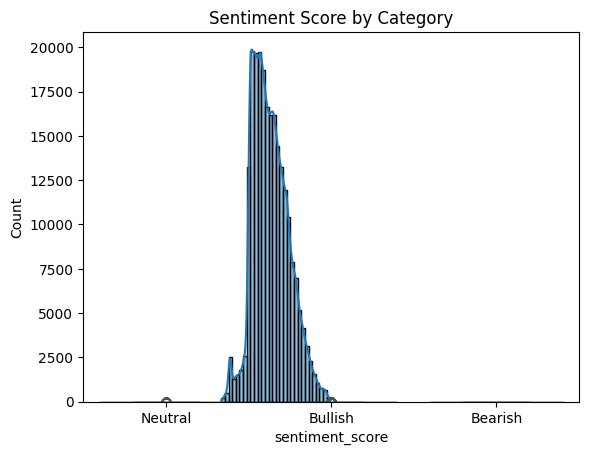

In [19]:
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Sentiment Score Distribution')

sns.boxplot(x='sentiment', y='sentiment_score', data=df)
plt.title('Sentiment Score by Category')


<Axes: title={'center': 'Daily Sentiment Counts'}, xlabel='date_clean'>

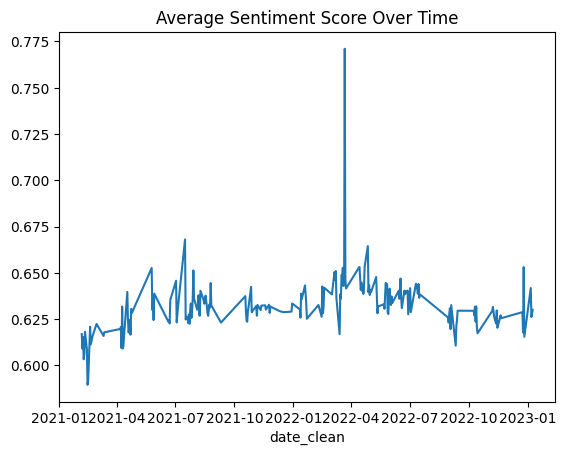

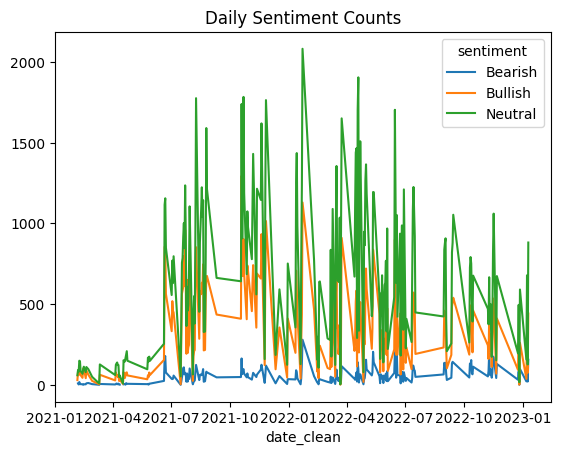

In [20]:
daily_sentiment = df.groupby(df['date_clean'].dt.date)['sentiment_score'].mean()
daily_sentiment.plot(title='Average Sentiment Score Over Time')

sentiment_counts = df.groupby([df['date_clean'].dt.date, 'sentiment']).size().unstack()
sentiment_counts.plot(title='Daily Sentiment Counts')


**Average Sentiment Score**

The average sentiment score mostly fluctuates within a narrow band between 0.60 and 0.65, suggesting moderately positive or neutral sentiment over time. There's a sharp spike around early 2022 where the sentiment briefly reaches nearly 0.77, which is anomalously high. This may indicate a sudden surge in positive news or social media sentiment (could be driven by a major event in the crypto world). Despite daily noise, the overall trend appears relatively stable with no clear upward or downward drift over the long term.

**Daily Sentiment Counts**

The Neutral sentiment dominates the daily counts throughout the period — usually by a large margin — suggesting that most messages/posts are not strongly polarized. Bullish sentiment appears more frequently than Bearish, but both show a lot of volatility and random spikes. There are clear high-activity periods (e.g., late 2021 and early 2022), where counts for all sentiment types spike, likely due to increased public interest or market volatility.

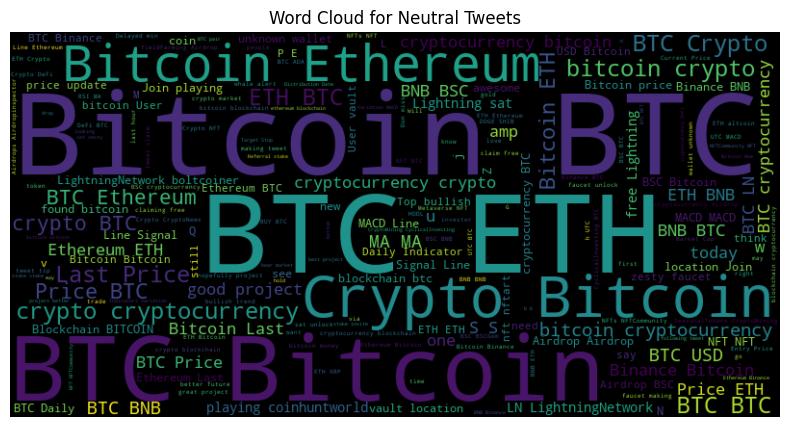

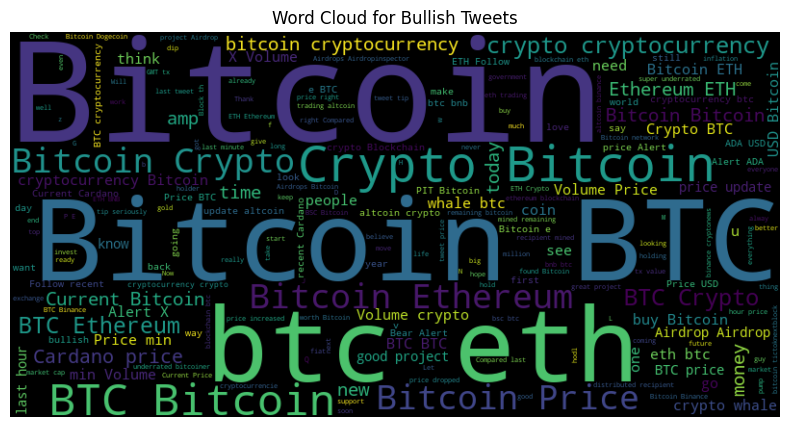

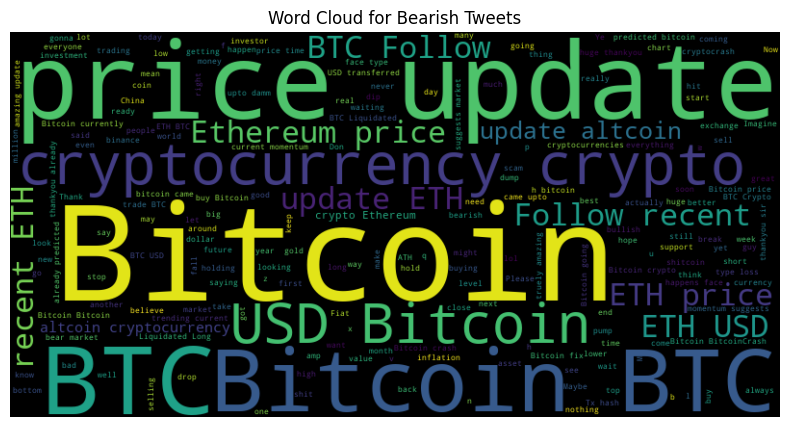

In [21]:
from wordcloud import WordCloud

for sentiment in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_tweets'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.axis('off')
    plt.show()


Cryptocurrency Tweet Sentiment Analysis: Word Cloud Interpretations


1. Neutral Tweets

Focus: General discussion and information sharing primarily about Bitcoin (BTC) and Ethereum (ETH).


Key Themes:
Price updates and market data (e.g., "price," "update"). 

Technical analysis terms ("MACD," "Signal Line," "Daily Indicator").

Community engagement ("join," "User," "airdrop").

Mentions of specific technologies ("Lightning Network," "BNB").

Overall: Reflects an observational or informational stance on current crypto events and features without strong emotional bias.


2. Bullish Tweets

Focus: Optimistic sentiment regarding price increases, primarily for Bitcoin (BTC) and Ethereum (ETH).


Key Themes:

Strong positive price expectations ("pump," "bullish," "future," "hope").

Calls to action for buying and investing ("buy," "invest," "hold").

Discussions of market drivers ("Volume," "whale").

Positive outlook on specific projects ("good project").

Includes other altcoins like Cardano ("ADA").

Overall: Characterized by excitement, anticipation of growth, and active buying/holding strategies.


3. Bearish Tweets

Focus: Pessimistic sentiment regarding price decreases for Bitcoin (BTC), Ethereum (ETH), and other cryptocurrencies.


Key Themes:

Negative price expectations ("dump," "bearish," "drop," "crash," "liquidated").

Emphasis on selling ("sell") and market risks ("risk," "inflation," "bad").

Reactions to recent negative market developments ("Follow," "update," "recent").

Reference to USD, possibly as a flight to safety or for valuation.

Overall: Highlights concerns about falling prices, market instability, and often reflects a reactive stance to negative news or price movements.

/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_43881/1959671767.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


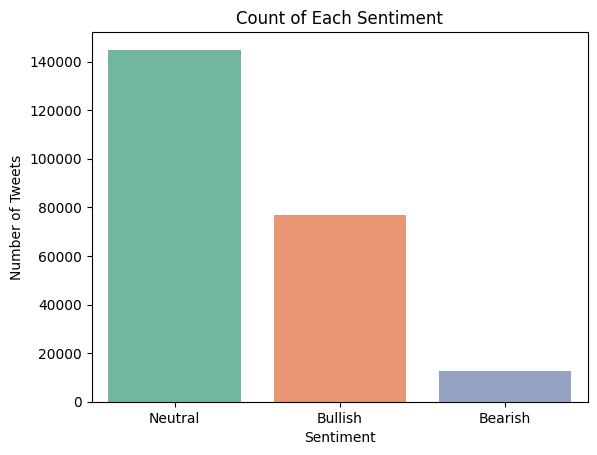

In [22]:
# Plot count of each sentiment
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

The bar chart displays the "Count of Each Sentiment" found within a Twitter dataset.

* Dominant Sentiment: Neutral tweets are the most prevalent, numbering approximately 145,000. This suggests that a large portion of the discussions in this dataset are informational, observational, or do not express strong positive or negative opinions.

* Bullish Sentiment: Bullish (positive) tweets are the second most common category, with a count of around 78,000. This indicates a significant volume of optimistic discussion.

* Bearish Sentiment: Bearish (negative) tweets are the least frequent, with approximately 13,000 tweets.

* Overall Distribution: The data shows a clear hierarchy in sentiment frequency: Neutral > Bullish > Bearish. This implies that, for the topics covered in this dataset, general discussion and optimistic viewpoints are considerably more common than pessimistic ones.

## Data Integration

In [23]:
print(df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score'],
      dtype='object')


We will add some of the important cryptos into our dataset to help in predicting the BTC prices:

In [25]:
# Updated function to get multiple crypto prices
def get_crypto_prices(tickers=['BTC-USD'], start_date='2020-01-01', end_date='2023-12-31'):
    data = {}
    for ticker in tickers:
        crypto = yf.Ticker(ticker)
        hist = crypto.history(start=start_date, end=end_date)
        if not hist.empty:
            sym = ticker.split('-')[0]
            # price series
            data[sym] = hist['Close']
            # volume series
            data[f'{sym}_volume'] = hist['Volume']
    return pd.DataFrame(data)

# Get prices for all cryptos
top_cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']
price_df = get_crypto_prices(top_cryptos)

# Ensure the index of price_df is timezone-naive datetime
price_df.index = price_df.index.tz_localize(None)

# Ensure df['date_clean'] is in datetime format
df['date_clean'] = pd.to_datetime(df['date_clean'])

# Merge on datetime keys
merged_df = pd.merge(df,
                     price_df,
                     left_on='date_clean',
                     right_index=True,
                     how='inner')


In [26]:
print(merged_df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score', 'BTC', 'BTC_volume', 'ETH', 'ETH_volume', 'BNB',
       'BNB_volume', 'ADA', 'ADA_volume', 'SOL', 'SOL_volume', 'XRP',
       'XRP_volume'],
      dtype='object')


Let's look at the dataset:

In [28]:
merged_df.head()

tweets  \
0  Bitcoin BTC current price (GBP): £27,618\nLike...   
1  Tune in to : The Bitcoin Revolution Isn't Comi...   
2  Bitcoin BTC Crypto \nThe last few months of BT...   
3  IF YOUR IN CRYPTO BE CAREFUL!!!\nTHIS IS A SCA...   
4  This is not just a billionaire! \n\nHe is the ...   

                                      cleaned_tweets date_clean sentiment  \
0  Bitcoin BTC current price GBP Like update tip ... 2021-02-05   Neutral   
1  Tune The Bitcoin Revolution Isn Coming It Alre... 2021-02-05   Bullish   
2  Bitcoin BTC Crypto The last month BTC bootcamp... 2021-02-05   Bullish   
3  IF YOUR IN CRYPTO BE CAREFUL THIS IS A SCAM Cr... 2021-02-05   Neutral   
4  This billionaire He richest human EARTH Some p... 2021-02-05   Bullish   

   sentiment_score           BTC   BTC_volume          ETH   ETH_volume  \
0         0.859732  38144.308594  58598066402  1718.650879  40108628454   
1         0.576274  38144.308594  58598066402  1718.650879  40108628454   
2         0.546551  38144.308594  58598066402  1718.650879  40108628454   
3         0.701728  38144.308594  58598066402  1718.650879  40108628454   
4         0.529897  38144.308594  58598066402  1718.650879  40108628454   

         BNB  BNB_volume       ADA  ADA_volume      SOL  SOL_volume       XRP  \
0  67.845566  1431595319  0.537874  6808411307  6.68172  92892157.0  0.450047   
1  67.845566  1431595319  0.537874  6808411307  6.68172  92892157.0  0.450047   
2  67.845566  1431595319  0.537874  6808411307  6.68172  92892157.0  0.450047   
3  67.845566  1431595319  0.537874  6808411307  6.68172  92892157.0  0.450047   
4  67.845566  1431595319  0.537874  6808411307  6.68172  92892157.0  0.450047   

    XRP_volume  
0  10229060640  
1  10229060640  
2  10229060640  
3  10229060640  
4  10229060640

#### Feature Importance

            Feature    Importance
5               XRP  6.501954e-01
1               ETH  3.058412e-01
4               SOL  1.792069e-02
3               ADA  1.591939e-02
8        ADA_volume  3.140522e-03
2               BNB  2.280158e-03
10       XRP_volume  2.052578e-03
7        BNB_volume  1.195875e-03
6        ETH_volume  8.059131e-04
9        SOL_volume  6.483392e-04
0   sentiment_score  1.013224e-13


/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_43881/3487938279.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


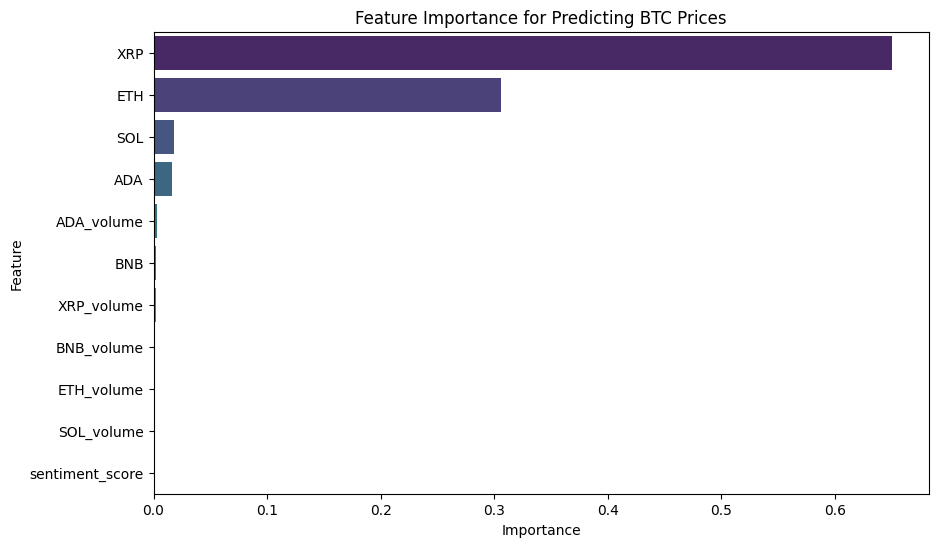

In [29]:
# Define the features (independent variables)
features = merged_df[['sentiment_score', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP', 'ETH_volume', 'BNB_volume', 'ADA_volume', 'SOL_volume', 'XRP_volume']]

# Define the target (dependent variable), e.g., BTC prices
target = merged_df['BTC']

# Train a RandomForest model using the features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features, target)

# Extract feature importances and create a DataFrame to visualize
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the features by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Predicting BTC Prices')
plt.show()

We can look at the results from the feature importance and deduce that sentiment score has the least importance. This means it doesn't play an important role in prediction of the BTC prices.

#### Model Training

In [79]:
# 1. Features and Target
features = merged_df[['sentiment_score', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP',
                      'ETH_volume', 'BNB_volume', 'ADA_volume', 'SOL_volume', 'XRP_volume']]
target = merged_df['BTC']

In [80]:
# 2. Train/Validation/Test Split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.10, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=False)

In [81]:
# 3. Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [82]:
# 4. Predict on validation and test sets
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

# 5. Evaluation metrics (on test set)
mse = mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.4f}")


Test MSE: 190202684.12
Test R²: -97.1693


The R2 is in negative suggesting that the model is not capturing anything. Sentiment scores and other cryptos are not playing an important role in predicting the BTC prices. 

Moving on, we can look at other ways to better predict BTC prices. We will increase the dataset size and number of features to better capture the movement of BTC. It is to be noted that the crypto market is very volatile and accurately predicting its prices is very difficult. However, our model can help to better understand how the market moves and behaves.

## Crypto Model

We get the data from 2020 till 2025 of BTC, ETH, BNB, ADA, SOL, and XRP. 

In [2]:
# Define the crypto tickers and their labels
crypto_tickers = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
    'BNB-USD': 'BNB',
    'ADA-USD': 'ADA',
    'SOL-USD': 'SOL',
    'XRP-USD': 'XRP'
}

# Define the time range
start_date = '2020-04-10'
end_date = '2025-04-30'

In [3]:
# Download data
crypto_data = {}
for ticker in crypto_tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close', 'Volume']].rename(columns={'Close': crypto_tickers[ticker], 'Volume': f"{crypto_tickers[ticker]}_volume"})
    crypto_data[crypto_tickers[ticker]] = data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Lets look at the dataset:

In [4]:
# Combine all crypto data on date
crypto_ml_df = pd.concat(crypto_data.values(), axis=1, join='inner')
crypto_ml_df.reset_index(inplace=True)
crypto_ml_df.head()

Price        Date          BTC   BTC_volume         ETH   ETH_volume  \
Ticker                 BTC-USD      BTC-USD     ETH-USD      ETH-USD   
0      2020-04-10  6865.493164  43622840992  158.412445  17980944616   
1      2020-04-11  6859.083008  31222085946  158.216019  13555089447   
2      2020-04-12  6971.091797  35759567632  161.142426  15123721386   
3      2020-04-13  6845.037598  38619308647  156.279556  16465282133   
4      2020-04-14  6842.427734  34110434052  157.596390  14723156630   

Price         BNB BNB_volume       ADA ADA_volume       SOL SOL_volume  \
Ticker    BNB-USD    BNB-USD   ADA-USD    ADA-USD   SOL-USD    SOL-USD   
0       13.737724  394331907  0.033215   95977717  0.951054   87364276   
1       13.804288  364313702  0.033354   75648111  0.776819   43862444   
2       14.375111  414752932  0.033806   73751090  0.882507   38736897   
3       15.034427  459561236  0.033107   84000834  0.777832   18211285   
4       15.525076  515331620  0.032974   74633336  0.661925   16747614   

Price        XRP  XRP_volume  
Ticker   XRP-USD     XRP-USD  
0       0.187464  2105282079  
1       0.188063  1847482831  
2       0.190135  2087857417  
3       0.187732  2253497429  
4       0.185335  1889687587

We have the closing prices and volume traded of all the crypto currencies.

### Crypto EDA

In [5]:
# Creating a copy to avoid modifying original
crypto_scaled_df = crypto_ml_df.copy()


In [6]:
# Select only numeric columns to scale (excluding 'Date')
numeric_cols = crypto_scaled_df.select_dtypes(include='number').columns

In [7]:
# Initialize and apply scaler
scaler = MinMaxScaler()
crypto_scaled_df[numeric_cols] = scaler.fit_transform(crypto_scaled_df[numeric_cols])

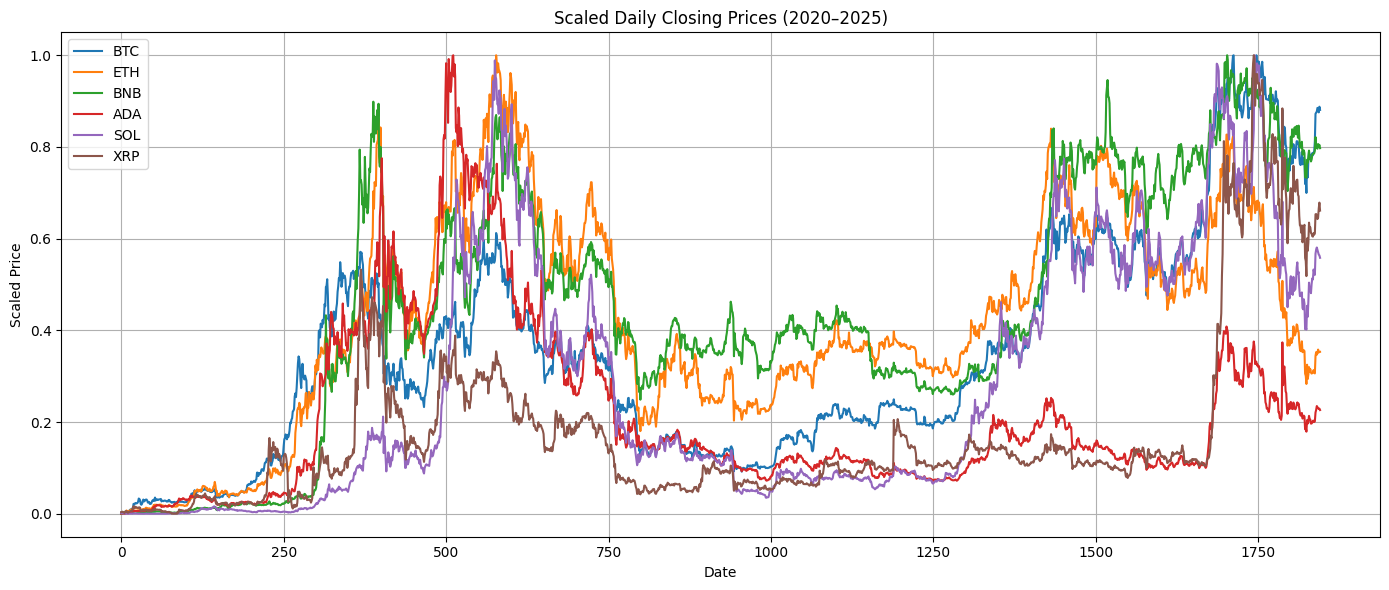

In [8]:
plt.figure(figsize=(14, 6))
for coin in ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']:
    plt.plot(crypto_scaled_df.index, crypto_scaled_df[coin], label=coin)

plt.title('Scaled Daily Closing Prices (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how the prices of several cryptocurrencies, like Bitcoin (BTC), Ethereum (ETH), Binance Coin (BNB), Cardano (ADA), Solana (SOL), and Ripple (XRP), have changed over time from 2020 to 2025. All prices are adjusted to a common scale to make them comparable. We can see periods where prices for many of these digital currencies moved up together and other times where they went down, often showing similar patterns of peaks and valleys, though some currencies experienced much larger relative changes than others.

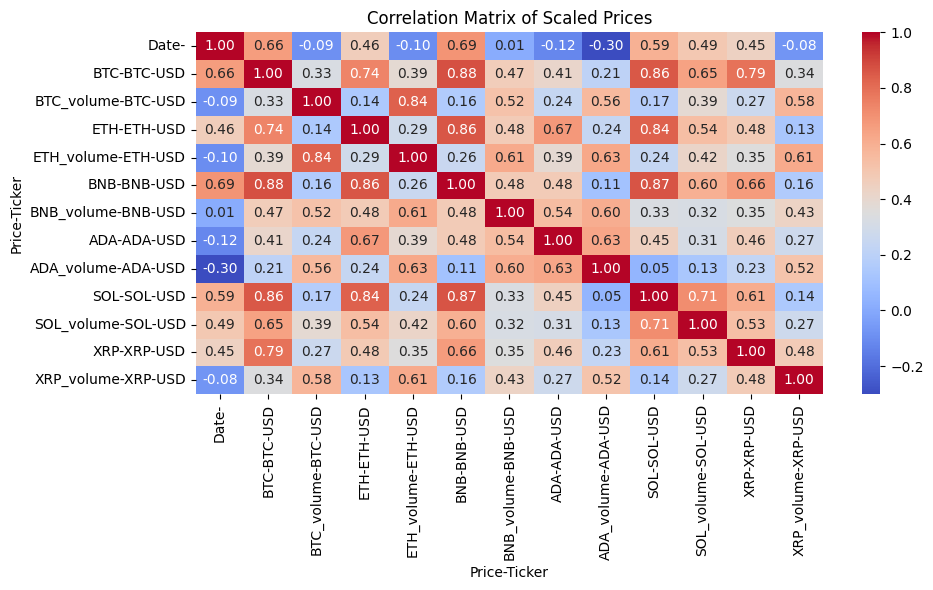

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(crypto_scaled_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Prices')
plt.tight_layout()
plt.show()


This colorful chart, called a heatmap, shows how the scaled prices and trading volumes of different cryptocurrencies and the date itself are related to each other. Red squares indicate a strong positive relationship, meaning when one goes up, the other tends to go up as well. Blue squares show a negative relationship, where one tends to go up when the other goes down. White or light-colored squares mean there's little to no clear relationship. For example, we can see how Bitcoin's price (BTC-BTC-USD) is strongly positively correlated with Ethereum's price (ETH-ETH-USD).

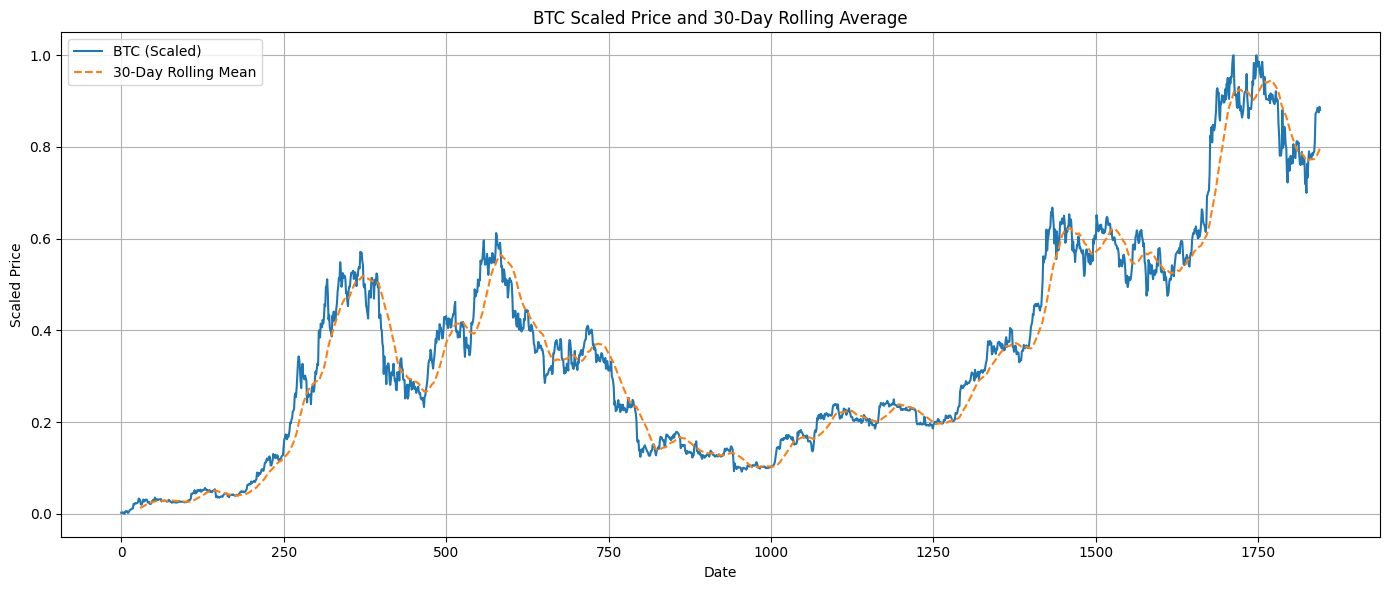

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'], label='BTC (Scaled)')
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'].rolling(window=30).mean(), 
         label='30-Day Rolling Mean', linestyle='--')

plt.title('BTC Scaled Price and 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This graph focuses on Bitcoin's scaled price over time, shown as a solid line. It also includes a dashed line representing the 30-day rolling average, which smooths out the daily price fluctuations. This average line helps to show the general trend of Bitcoin's price more clearly. When the actual price line is above the average line, it often suggests an upward trend, and when it's below, it might indicate a downward trend.

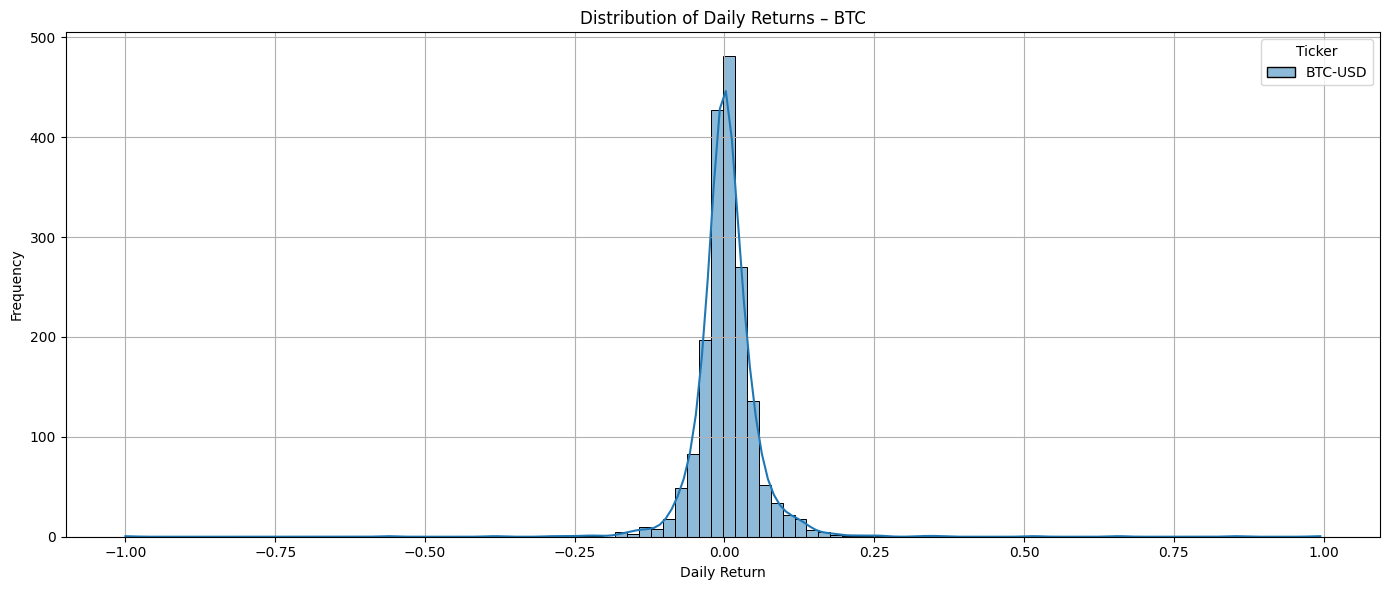

In [11]:
# Reset index so 'date' becomes a column temporarily
crypto_temp = crypto_scaled_df.reset_index()

# Compute daily returns (excluding 'date' column)
crypto_returns = crypto_temp[['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']].pct_change().dropna()

# Plot distribution for BTC
plt.figure(figsize=(14, 6))
sns.histplot(crypto_returns['BTC'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Daily Returns – BTC')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


This graph illustrates how often Bitcoin (BTC) experiences different daily percentage changes in its price. The tall peak in the middle, around zero, shows that very small daily changes (either slightly up or slightly down) are the most common. The graph quickly drops off on either side, meaning large daily gains or large daily losses are much rarer. This shape is typical for financial asset returns, showing mostly small movements with occasional larger ones.

<Figure size 1000x500 with 0 Axes>

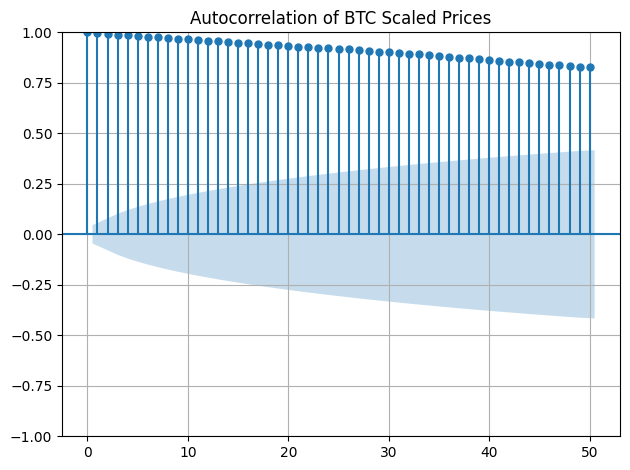

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(crypto_scaled_df['BTC'].dropna(), lags=50)
plt.title('Autocorrelation of BTC Scaled Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


This chart, known as an autocorrelation plot, examines how Bitcoin's scaled price at one point in time is related to its price at previous points in time (lags). Each vertical line represents the strength of this relationship for a different lag. The plot shows that Bitcoin's current price is very strongly related to its price from the recent past (e.g., one day ago, two days ago), and this relationship gradually weakens as we look further back in time. The shaded area helps to determine if these relationships are statistically significant.

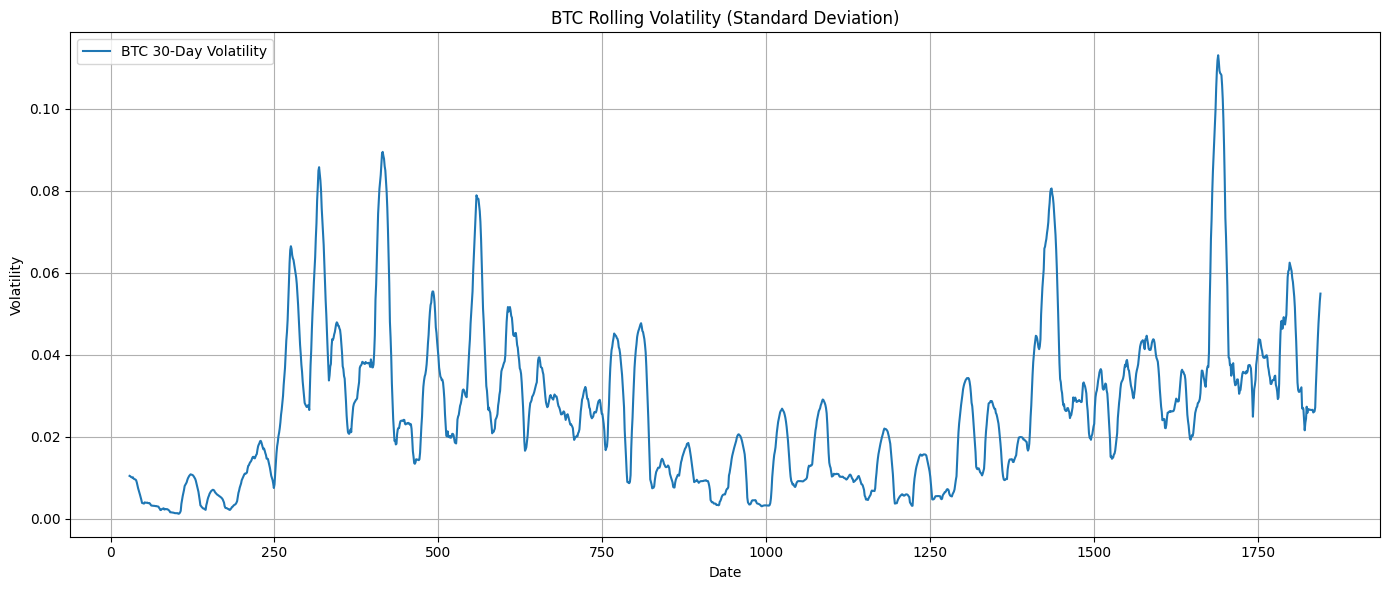

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df['BTC'].rolling(window=30).std(), label='BTC 30-Day Volatility')
plt.title('BTC Rolling Volatility (Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This graph displays Bitcoin's 30-day rolling volatility, which is a measure of how much its price tends to fluctuate over a 30-day period. Higher points on the line mean that Bitcoin's price was experiencing larger and more frequent swings during that time, indicating higher risk or uncertainty. Lower points mean the price was relatively more stable. The graph shows that Bitcoin's volatility changes over time, with periods of high price swings followed by periods of comparative calm.

#### Seasonal Decomposition

Columns in the dataframe: [('Date', ''), ('BTC', 'BTC-USD'), ('BTC_volume', 'BTC-USD'), ('ETH', 'ETH-USD'), ('ETH_volume', 'ETH-USD'), ('BNB', 'BNB-USD'), ('BNB_volume', 'BNB-USD'), ('ADA', 'ADA-USD'), ('ADA_volume', 'ADA-USD'), ('SOL', 'SOL-USD'), ('SOL_volume', 'SOL-USD'), ('XRP', 'XRP-USD'), ('XRP_volume', 'XRP-USD')]
Set '('Date', '')' column as the index


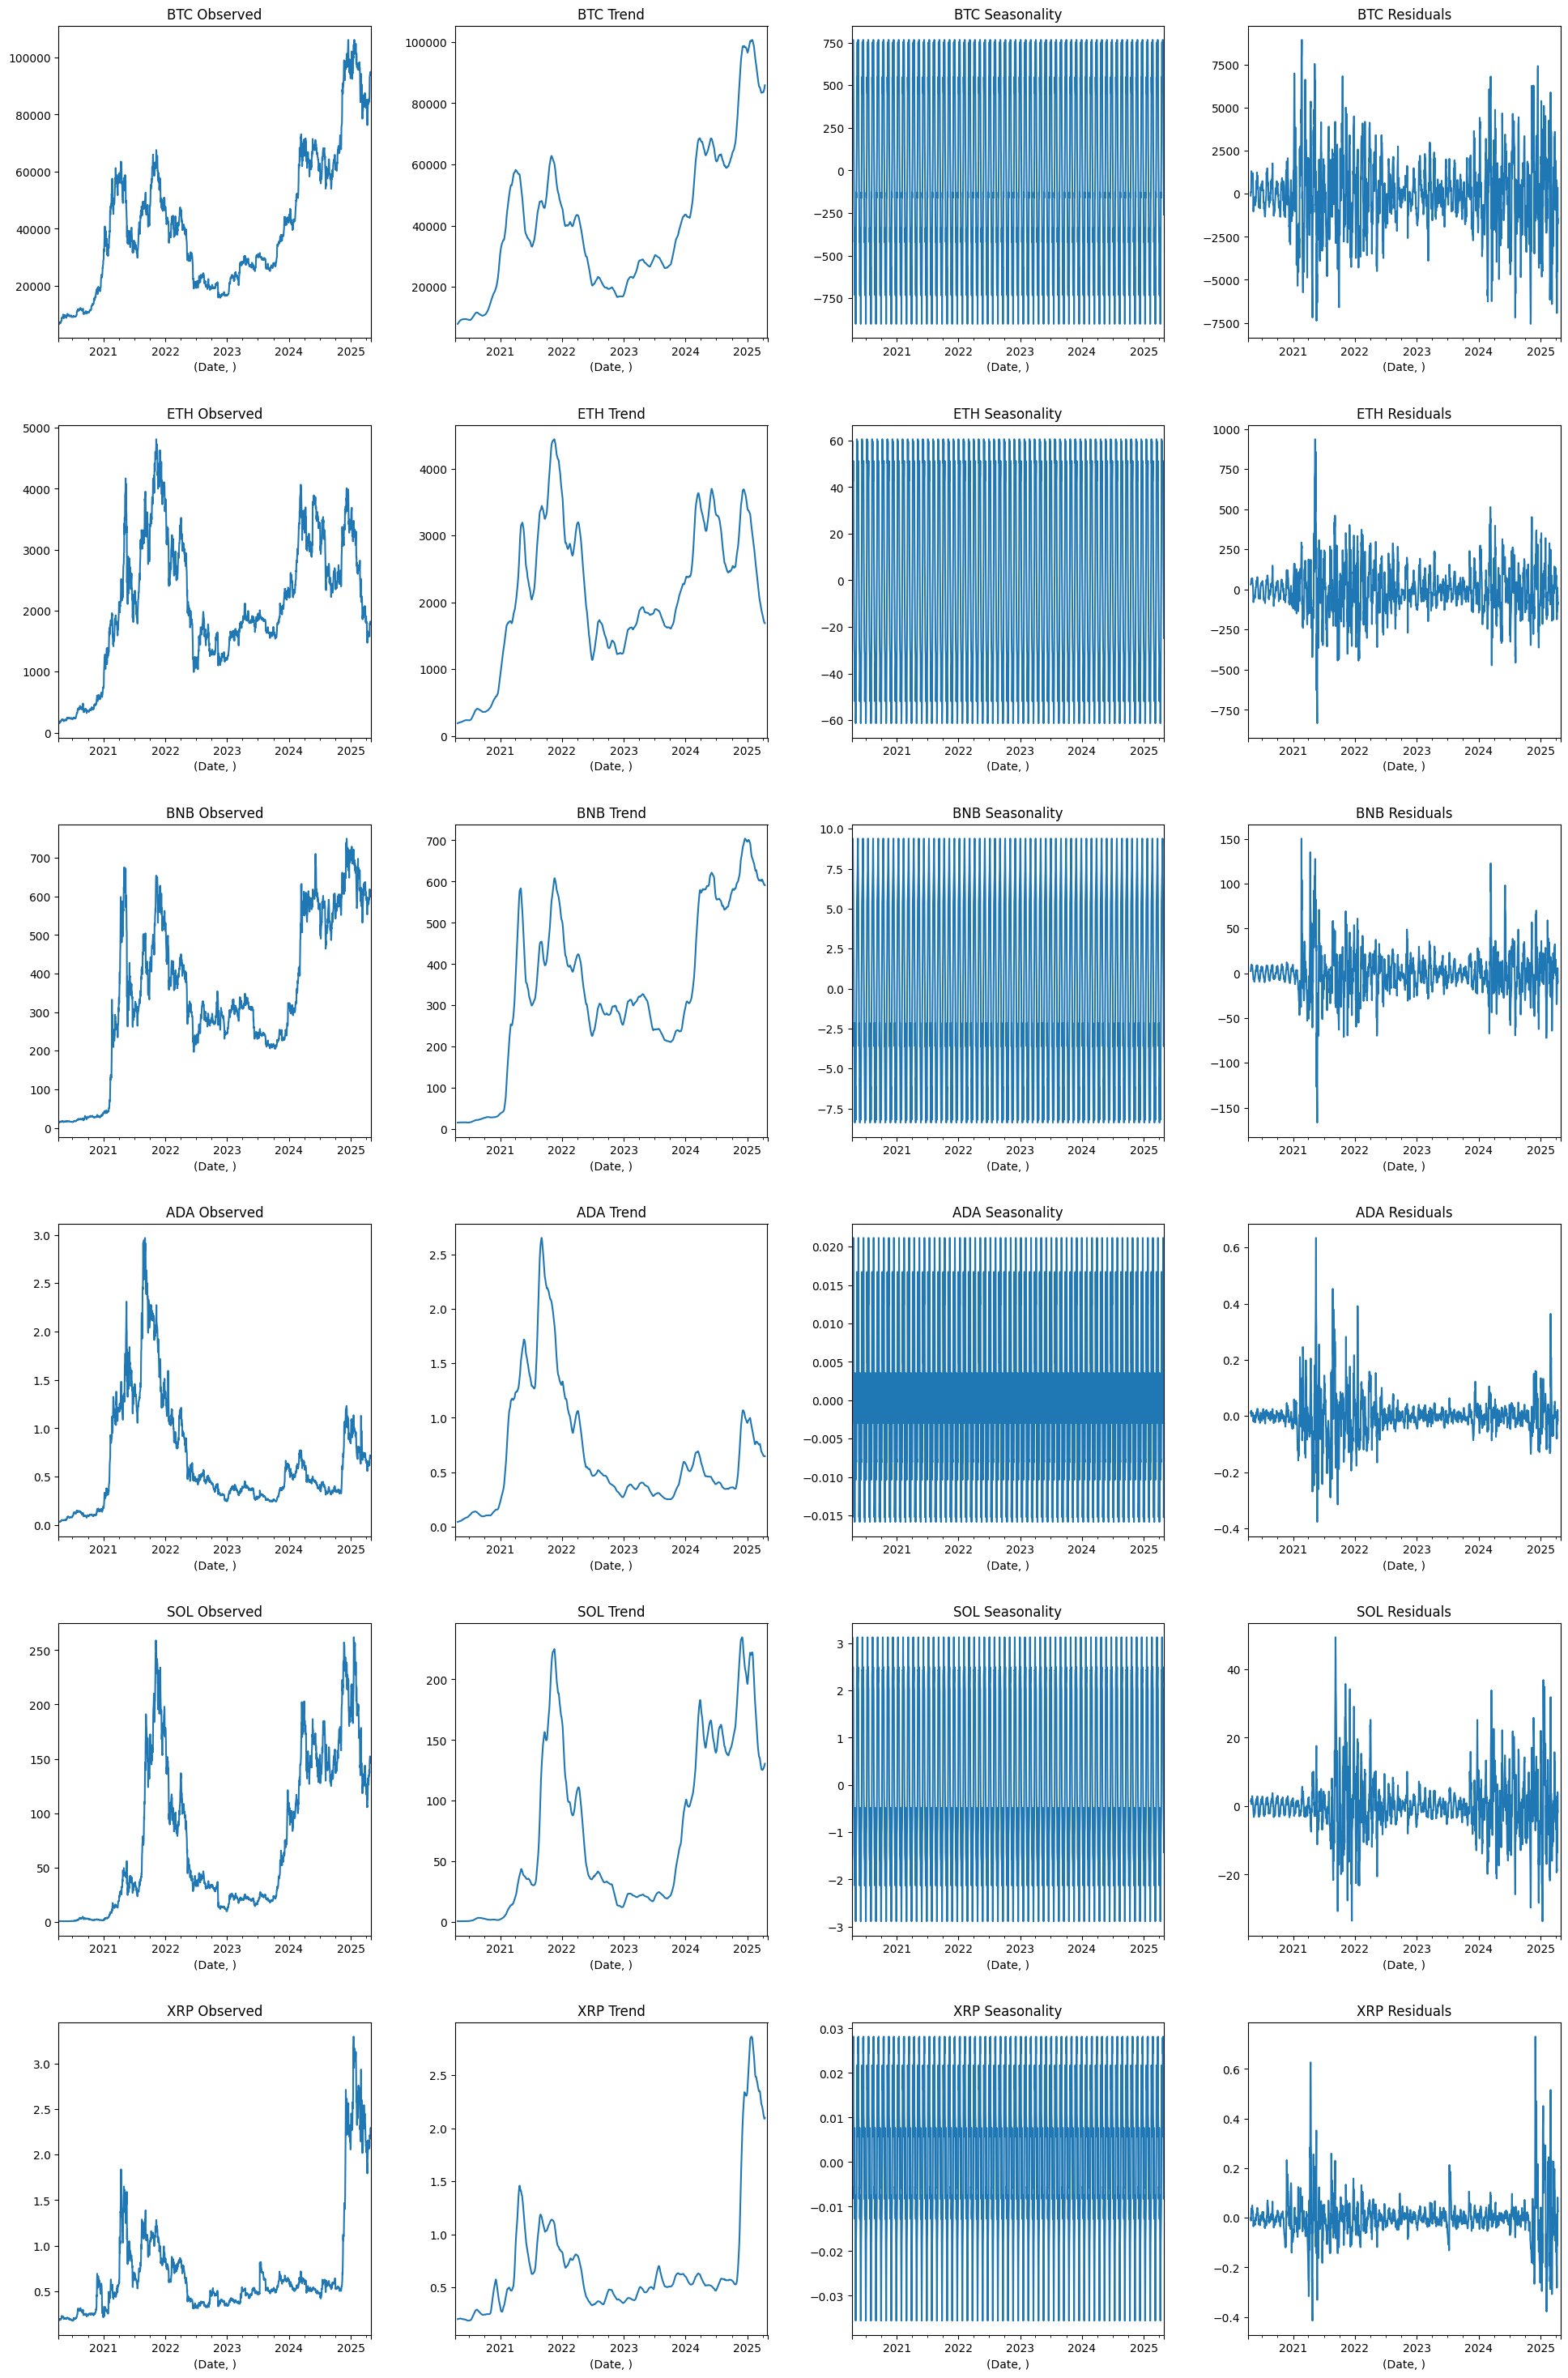

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create a figure for seasonal decomposition plots
plt.figure(figsize=(20, 30))
plot_counter = 1

# Dictionary to store decomposition results
decomposition_results = {}

# First, check what your index or date column is actually called
print("Columns in the dataframe:", crypto_ml_df.columns.tolist())

# Make a copy and ensure we have a proper datetime index
df_decomp = crypto_ml_df.copy()

# If the date is the index already
if isinstance(df_decomp.index, pd.DatetimeIndex):
    print("Index is already DatetimeIndex")
# If the date is a column called 'index' (common when reset_index was used)
elif 'index' in df_decomp.columns and pd.api.types.is_datetime64_any_dtype(df_decomp['index']):
    df_decomp = df_decomp.set_index('index')
    print("Set 'index' column as the index")
# Otherwise, find the date column (it might have a different name)
else:
    # Try to find a datetime column
    date_cols = [col for col in df_decomp.columns if pd.api.types.is_datetime64_any_dtype(df_decomp[col])]
    if date_cols:
        df_decomp = df_decomp.set_index(date_cols[0])
        print(f"Set '{date_cols[0]}' column as the index")
    else:
        # If we can't find a datetime column, use the first column and convert it
        print(f"Converting first column '{df_decomp.columns[0]}' to datetime index")
        df_decomp = df_decomp.set_index(df_decomp.columns[0])
        df_decomp.index = pd.to_datetime(df_decomp.index)

# Loop through each cryptocurrency
for coin in ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']:
    # Prepare time series data with appropriate index
    ts_data = df_decomp[coin]
    
    # Perform seasonal decomposition
    # You can adjust the period parameter based on the seasonality you expect
    decomposition = seasonal_decompose(ts_data, model='additive', period=30)
    
    # Store results for potential later use
    decomposition_results[coin] = decomposition
    
    # Plot all components
    plt.subplot(6, 4, plot_counter)
    decomposition.observed.plot()
    plt.title(f'{coin} Observed')
    plt.tight_layout()
    plot_counter += 1
    
    plt.subplot(6, 4, plot_counter)
    decomposition.trend.plot()
    plt.title(f'{coin} Trend')
    plt.tight_layout()
    plot_counter += 1
    
    plt.subplot(6, 4, plot_counter)
    decomposition.seasonal.plot()
    plt.title(f'{coin} Seasonality')
    plt.tight_layout()
    plot_counter += 1
    
    plt.subplot(6, 4, plot_counter)
    decomposition.resid.plot()
    plt.title(f'{coin} Residuals')
    plt.tight_layout()
    plot_counter += 1

plt.tight_layout(pad=3.0)
plt.show()

### Interpretation of Seasonal Decomposition

The figure illustrates the seasonal decomposition of cryptocurrency prices for **BTC**, **ETH**, **BNB**, **ADA**, **SOL**, and **XRP**. Seasonal decomposition is a technique used to break down a time series into its core components: **trend**, **seasonality**, and **residuals**. This analysis uses the **additive model** with a **period of 30**, assuming the time series can be expressed as the **sum** of its components, with seasonal patterns repeating every 30 time units.

---

#### Components Explained

- **Observed**  
  Represents the original cryptocurrency price data.

- **Trend**  
  Captures the long-term direction of price movements. It shows the general upward or downward trajectory over time.

- **Seasonality**  
  Isolates recurring, short-term patterns within the data. With a 30-day period, this could reflect **monthly fluctuations**, though identifying true "seasonality" in crypto requires caution.

- **Residuals**  
  Represents the irregular, random noise remaining after removing trend and seasonal components. This captures unpredictable variations in the data.

---

#### Key Observations and Implications

- **Dominant Trend**  
  A clear **upward trend** is evident for most cryptocurrencies (BTC, ETH, BNB, ADA, SOL, and XRP). This aligns with the overall growth seen in the crypto market over recent years.

- **Weak Seasonality**  
  The **seasonal component** is relatively weak across all assets. There are no strong or consistent repeating price patterns within the 30-day window. This suggests short-term price movements aren't significantly driven by regular, cyclical behaviors.

- **Irregularity of Residuals**  
  The **residual component** displays high volatility and irregularity. This indicates that crypto prices are strongly influenced by **unpredictable external factors**, such as market sentiment, news, and regulatory developments. The **large magnitude** of residuals—compared to seasonality—emphasizes the **limited role of seasonal patterns** in crypto price behavior.

---

In summary, the seasonal decomposition reveals that while cryptocurrency prices exhibit a **general upward trend**, they **lack strong, regular seasonal patterns**. Instead, price movements are largely driven by **unpredictable factors**, as reflected in the substantial magnitude of the residual component.


### Model Training

#### Feature Engineering

In [15]:
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [16]:
# Make plots larger and more readable
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# First, let's check what our dataset looks like
print("Dataset shape:", crypto_ml_df.shape)
print("\nFirst 5 rows:")
display(crypto_ml_df.head())

# Check for missing values
print("\nMissing values:")
print(crypto_ml_df.isnull().sum())

# Convert Date column to datetime format if not already
if not pd.api.types.is_datetime64_any_dtype(crypto_ml_df['Date']):
    crypto_ml_df['Date'] = pd.to_datetime(crypto_ml_df['Date'])

# Set Date as index
crypto_ml_df.set_index('Date', inplace=True)

# Sort by date to ensure chronological order
crypto_ml_df.sort_index(inplace=True)

# Display basic statistics
print("\nBasic statistics:")
display(crypto_ml_df.describe())


Dataset shape: (1846, 13)

First 5 rows:


Price        Date          BTC   BTC_volume         ETH   ETH_volume  \
Ticker                 BTC-USD      BTC-USD     ETH-USD      ETH-USD   
0      2020-04-10  6865.493164  43622840992  158.412445  17980944616   
1      2020-04-11  6859.083008  31222085946  158.216019  13555089447   
2      2020-04-12  6971.091797  35759567632  161.142426  15123721386   
3      2020-04-13  6845.037598  38619308647  156.279556  16465282133   
4      2020-04-14  6842.427734  34110434052  157.596390  14723156630   

Price         BNB BNB_volume       ADA ADA_volume       SOL SOL_volume  \
Ticker    BNB-USD    BNB-USD   ADA-USD    ADA-USD   SOL-USD    SOL-USD   
0       13.737724  394331907  0.033215   95977717  0.951054   87364276   
1       13.804288  364313702  0.033354   75648111  0.776819   43862444   
2       14.375111  414752932  0.033806   73751090  0.882507   38736897   
3       15.034427  459561236  0.033107   84000834  0.777832   18211285   
4       15.525076  515331620  0.032974   74633336  0.661925   16747614   

Price        XRP  XRP_volume  
Ticker   XRP-USD     XRP-USD  
0       0.187464  2105282079  
1       0.188063  1847482831  
2       0.190135  2087857417  
3       0.187732  2253497429  
4       0.185335  1889687587


Missing values:
Price       Ticker 
Date                   0
BTC         BTC-USD    0
BTC_volume  BTC-USD    0
ETH         ETH-USD    0
ETH_volume  ETH-USD    0
BNB         BNB-USD    0
BNB_volume  BNB-USD    0
ADA         ADA-USD    0
ADA_volume  ADA-USD    0
SOL         SOL-USD    0
SOL_volume  SOL-USD    0
XRP         XRP-USD    0
XRP_volume  XRP-USD    0
dtype: int64

Basic statistics:


Price             BTC    BTC_volume          ETH    ETH_volume          BNB  \
Ticker        BTC-USD       BTC-USD      ETH-USD       ETH-USD      BNB-USD   
count     1846.000000  1.846000e+03  1846.000000  1.846000e+03  1846.000000   
mean     41409.036062  3.356761e+10  2108.780745  1.709505e+10   343.314414   
std      23948.192080  2.024404e+10  1073.111682  1.091745e+10   197.773702   
min       6642.109863  5.331173e+09   153.286896  2.081626e+09    13.737724   
25%      22632.334961  2.043979e+10  1516.558167  9.640550e+09   237.622849   
50%      37324.607422  2.963824e+10  1937.230713  1.488192e+10   313.467438   
75%      58192.470703  4.075462e+10  2961.470825  2.116080e+10   529.586929   
max     106146.265625  3.509679e+11  4812.087402  9.245355e+10   750.272644   

Price     BNB_volume          ADA    ADA_volume          SOL    SOL_volume  \
Ticker       BNB-USD      ADA-USD       ADA-USD      SOL-USD       SOL-USD   
count   1.846000e+03  1846.000000  1.846000e+03  1846.000000  1.846000e+03   
mean    1.511664e+09     0.662946  1.400200e+09    74.935236  1.790551e+09   
std     1.374472e+09     0.560069  2.030534e+09    70.881991  2.277911e+09   
min     1.365992e+08     0.031863  5.825736e+07     0.515273  6.520200e+05   
25%     5.309764e+08     0.314543  3.022042e+08    19.182549  2.783352e+08   
50%     1.302818e+09     0.451191  6.364651e+08    38.678888  1.146799e+09   
75%     1.953729e+09     0.923297  1.535035e+09   138.468311  2.585399e+09   
max     1.798295e+10     2.968239  1.914198e+10   261.869751  3.317296e+10   

Price           XRP    XRP_volume  
Ticker      XRP-USD       XRP-USD  
count   1846.000000  1.846000e+03  
mean       0.717463  3.368577e+09  
std        0.581058  4.538622e+09  
min        0.175870  2.253910e+08  
25%        0.390422  1.094784e+09  
50%        0.529640  1.773782e+09  
75%        0.759323  3.457406e+09  
max        3.298635  5.172338e+10

In [17]:
# Create a new dataframe to work with, focusing on BTC
btc_df = crypto_ml_df[['BTC', 'BTC_volume']].copy()

**Feature Engineering: Creating Lagged Price Features**

Lagged price features are created by shifting the Bitcoin closing price column by a specified number of days (e.g., up to 31 days). Including lagged prices allows the models, particularly non-sequential ones like Random Forest and XGBoost, to leverage past price information directly as input features, capturing temporal dependencies explicitly.

In [18]:
# Feature 1: Add lag features (previous days' prices)
for i in range(1, 31):
    btc_df[f'BTC_lag_{i}'] = btc_df['BTC'].shift(i)

In [19]:
# Feature 2: Rolling statistics
btc_df['rolling_mean_7d'] = btc_df['BTC'].rolling(window=7).mean()
btc_df['rolling_mean_30d'] = btc_df['BTC'].rolling(window=30).mean()
btc_df['rolling_std_7d'] = btc_df['BTC'].rolling(window=7).std()
btc_df['rolling_std_30d'] = btc_df['BTC'].rolling(window=30).std()

In [20]:
# Feature 3: Technical indicators
# Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc_df['RSI_14'] = calculate_rsi(btc_df['BTC'], 14)

In [21]:
# Moving Average Convergence Divergence (MACD)
btc_df['EMA_12'] = btc_df['BTC'].ewm(span=12, adjust=False).mean()
btc_df['EMA_26'] = btc_df['BTC'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = btc_df['EMA_12'] - btc_df['EMA_26']
btc_df['MACD_signal'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

**Feature Engineering: Extracting Temporal Features**

Temporal features, such as the day of the week and the month, are extracted from the date index. These features can help models identify potential daily or monthly patterns or seasonality in the price data, although strong seasonality is less expected in highly volatile markets like cryptocurrency.

In [22]:
# Feature 4: Calendar features
btc_df['day_of_week'] = btc_df.index.dayofweek
btc_df['month'] = btc_df.index.month

In [23]:
# Feature 5: Add other crypto prices as features
crypto_list = ['ETH', 'BNB', 'ADA', 'SOL', 'XRP']

for crypto in crypto_list:
    try:
        if crypto in crypto_ml_df.columns:
            btc_df[crypto] = crypto_ml_df[crypto]
            print(f"Added {crypto} as a feature")
    except Exception as e:
        print(f"Error adding {crypto}: {e}")


Added ETH as a feature
Added BNB as a feature
Added ADA as a feature
Added SOL as a feature
Added XRP as a feature


In [24]:
# Drop rows with NaN values (these will be at the beginning due to lag features)
btc_df.dropna(inplace=True)


In [25]:
# Display the features we've created
print("\nFeatures after engineering:")
print(btc_df.columns.tolist())


Features after engineering:
[('BTC', 'BTC-USD'), ('BTC_volume', 'BTC-USD'), ('BTC_lag_1', ''), ('BTC_lag_2', ''), ('BTC_lag_3', ''), ('BTC_lag_4', ''), ('BTC_lag_5', ''), ('BTC_lag_6', ''), ('BTC_lag_7', ''), ('BTC_lag_8', ''), ('BTC_lag_9', ''), ('BTC_lag_10', ''), ('BTC_lag_11', ''), ('BTC_lag_12', ''), ('BTC_lag_13', ''), ('BTC_lag_14', ''), ('BTC_lag_15', ''), ('BTC_lag_16', ''), ('BTC_lag_17', ''), ('BTC_lag_18', ''), ('BTC_lag_19', ''), ('BTC_lag_20', ''), ('BTC_lag_21', ''), ('BTC_lag_22', ''), ('BTC_lag_23', ''), ('BTC_lag_24', ''), ('BTC_lag_25', ''), ('BTC_lag_26', ''), ('BTC_lag_27', ''), ('BTC_lag_28', ''), ('BTC_lag_29', ''), ('BTC_lag_30', ''), ('rolling_mean_7d', ''), ('rolling_mean_30d', ''), ('rolling_std_7d', ''), ('rolling_std_30d', ''), ('RSI_14', ''), ('EMA_12', ''), ('EMA_26', ''), ('MACD', ''), ('MACD_signal', ''), ('day_of_week', ''), ('month', ''), ('ETH', ''), ('BNB', ''), ('ADA', ''), ('SOL', ''), ('XRP', '')]


In [26]:
# Display the processed dataframe
print("\nProcessed data shape:", btc_df.shape)
display(btc_df.head())


Processed data shape: (1816, 48)


Price               BTC   BTC_volume    BTC_lag_1    BTC_lag_2    BTC_lag_3  \
Ticker          BTC-USD      BTC-USD                                          
Date                                                                          
2020-05-10  8756.430664  63325279337  9593.896484  9842.666016  9951.518555   
2020-05-11  8601.795898  57119858802  8756.430664  9593.896484  9842.666016   
2020-05-12  8804.477539  42142717533  8601.795898  8756.430664  9593.896484   
2020-05-13  9269.987305  45558144023  8804.477539  8601.795898  8756.430664   
2020-05-14  9733.721680  56426907637  9269.987305  8804.477539  8601.795898   

Price         BTC_lag_4    BTC_lag_5    BTC_lag_6    BTC_lag_7    BTC_lag_8  \
Ticker                                                                        
Date                                                                          
2020-05-10  9268.761719  9003.070312  8912.654297  8897.468750  8988.596680   
2020-05-11  9951.518555  9268.761719  9003.070312  8912.654297  8897.468750   
2020-05-12  9842.666016  9951.518555  9268.761719  9003.070312  8912.654297   
2020-05-13  9593.896484  9842.666016  9951.518555  9268.761719  9003.070312   
2020-05-14  8756.430664  9593.896484  9842.666016  9951.518555  9268.761719   

Price       ...       EMA_26        MACD MACD_signal day_of_week month  \
Ticker      ...                                                          
Date        ...                                                          
2020-05-10  ...  8402.581976  598.179882  556.974947           6     5   
2020-05-11  ...  8417.338563  522.043917  549.988741           0     5   
2020-05-12  ...  8446.015524  472.612349  534.513463           1     5   
2020-05-13  ...  8507.050471  465.632700  520.737310           2     5   
2020-05-14  ...  8597.915005  491.851013  514.960051           3     5   

Price              ETH        BNB       ADA       SOL       XRP  
Ticker                                                           
Date                                                             
2020-05-10  188.599564  15.295669  0.047677  0.537034  0.198176  
2020-05-11  185.912842  15.097545  0.048108  0.515273  0.194064  
2020-05-12  189.312500  15.741054  0.050421  0.538576  0.197637  
2020-05-13  199.193283  16.138878  0.051472  0.550532  0.201480  
2020-05-14  202.949097  16.357800  0.050890  0.569118  0.203129  

[5 rows x 48 columns]

#### Data Scaling

In [27]:
# Define features and target
X = btc_df.drop('BTC', axis=1)  # All features
y = btc_df['BTC']               # Target

# Scale features before feature selection
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_55889/2008361617.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = btc_df.drop('BTC', axis=1)  # All features


#### Feature Selection

In [28]:
# Train a model for feature selection
print("Training a Random Forest model for feature selection")
selector_model = RandomForestRegressor(n_estimators=100, random_state=42)
selector_model.fit(X_scaled, y)
importances = selector_model.feature_importances_

Training a Random Forest model for feature selection


In [29]:
# Create a DataFrame of features and their importance
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [30]:
# Choose top N features
top_n_features = 5
top_features = feature_importance.head(top_n_features)['Feature'].tolist()

print(f"Selected top {top_n_features} features:")
for i, feature in enumerate(top_features):
    importance = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].values[0]
    print(f"{i+1}. {feature}: {importance:.4f}")


Selected top 5 features:
1. ('BTC_lag_1', ''): 0.8814
2. ('BTC_lag_2', ''): 0.0258
3. ('EMA_12', ''): 0.0181
4. ('rolling_mean_7d', ''): 0.0176
5. ('BTC_lag_4', ''): 0.0147


In [31]:
# Apply feature selection
X_selected = X_scaled[top_features]


#### Target Variables and Train-Test Split

In [32]:
# Calculate split points
total_samples = len(X_selected)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)

In [33]:
# Split dates
train_end_date = X_selected.index[train_size - 1]
val_end_date = X_selected.index[train_size + val_size - 1]

print(f"Data range: {X_selected.index[0]} to {X_selected.index[-1]}")
print(f"Train data ends at: {train_end_date}")
print(f"Validation data ends at: {val_end_date}")

Data range: 2020-05-10 00:00:00 to 2025-04-29 00:00:00
Train data ends at: 2023-11-01 00:00:00
Validation data ends at: 2024-07-30 00:00:00


In [34]:
# Split data
X_train = X_selected[X_selected.index <= train_end_date]
X_val = X_selected[(X_selected.index > train_end_date) & (X_selected.index <= val_end_date)]
X_test = X_selected[X_selected.index > val_end_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index > val_end_date]

print("\nTraining data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (1271, 5)
Validation data shape: (272, 5)
Testing data shape: (273, 5)


In [35]:
# Scale y for models that need scaled targets (e.g., LSTM)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

#### Metrics Function

In [36]:
def calculate_metrics(y_true, y_pred):
    # Convert inputs to numpy arrays and flatten
    if hasattr(y_true, 'values'):
        y_true_values = y_true.values.flatten() if y_true.values.ndim > 1 else y_true.values
    else:
        y_true_values = np.array(y_true).flatten()
    
    if hasattr(y_pred, 'values'):
        y_pred_values = y_pred.values.flatten() if y_pred.values.ndim > 1 else y_pred.values
    else:
        y_pred_values = np.array(y_pred).flatten()
    
    # Ensure same length
    min_len = min(len(y_true_values), len(y_pred_values))
    y_true_values = y_true_values[:min_len]
    y_pred_values = y_pred_values[:min_len]
    
    # Calculate basic metrics
    mae = mean_absolute_error(y_true_values, y_pred_values)
    rmse = np.sqrt(mean_squared_error(y_true_values, y_pred_values))
    mape = mean_absolute_percentage_error(y_true_values, y_pred_values) * 100
    
    # Calculate directional accuracy safely
    if min_len >= 2:
        diff_true = np.diff(y_true_values)
        diff_pred = np.diff(y_pred_values)
        directional_accuracy = np.mean((diff_true > 0) == (diff_pred > 0)) * 100
    else:
        directional_accuracy = np.nan
    
    # Calculate R2
    r2 = r2_score(y_true_values, y_pred_values)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Directional Accuracy (%)': directional_accuracy,
        'R2': r2
    }

#### Time Series Modeling - ARIMA and Prophet

##### ARIMA Model

In [37]:
#Imports and Warning Suppression
import pmdarima as pm
import warnings
import traceback

# Suppress sklearn deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21631.330, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21632.800, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21633.853, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21633.880, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21631.184, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21635.805, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.610 seconds

📈 ARIMA Model Validation Metrics:
MAE: 20153.8909
RMSE: 23482.9265
MAPE: 32.8111
Directional Accuracy (%): 47.2325
R2: -2.7780

📈 ARIMA Model Test Metrics:
MAE: 18662.2728
RMSE: 22212.0501
MAPE: 20.8881
Directional Accuracy (%): 48.5294
R2: -0.9490


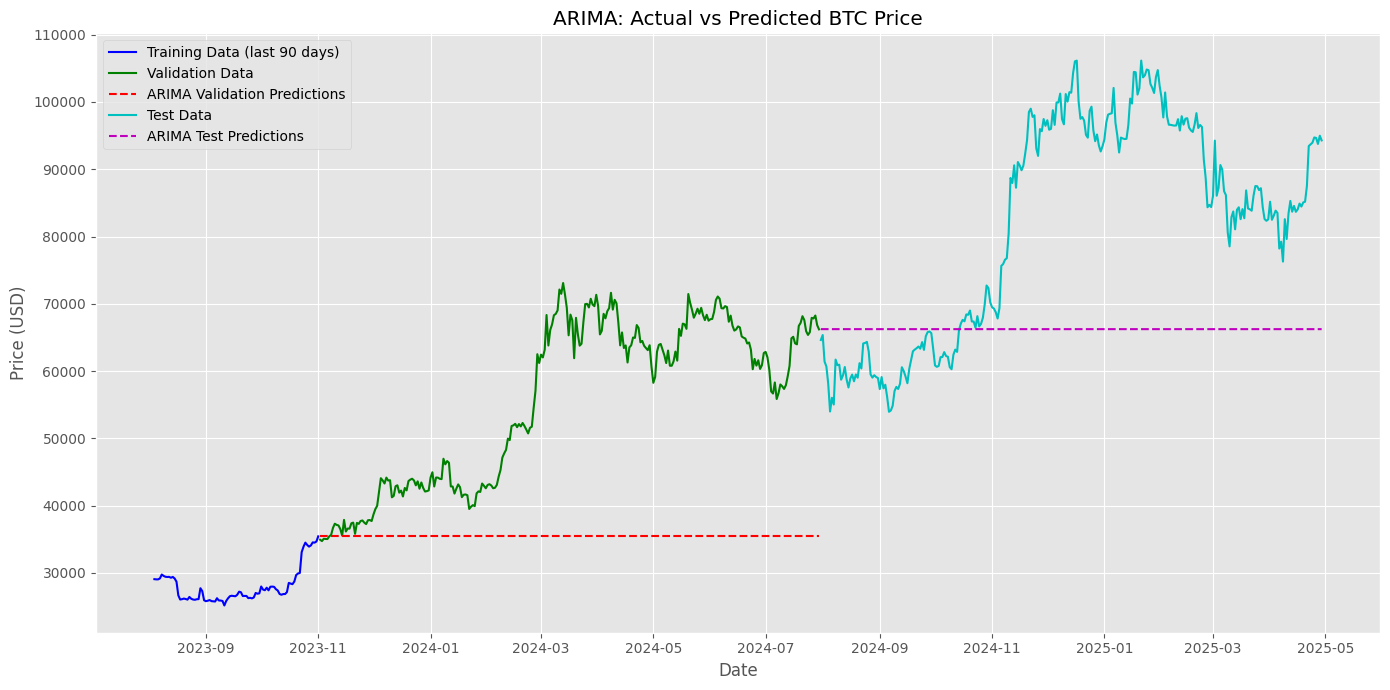

In [38]:
print("Fitting ARIMA model...")

try:
    # Prepare data for ARIMA
    y_train_series = pd.Series(y_train.values.flatten(), index=y_train.index)
    y_val_series = pd.Series(y_val.values.flatten(), index=y_val.index)
    y_test_series = pd.Series(y_test.values.flatten(), index=y_test.index)
    
    # Train on training data
    arima_model = pm.auto_arima(
        y_train_series,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        max_order=None,
        trace=True
    )
    
    # Forecast for validation
    n_periods_val = len(y_val_series)
    arima_val_preds_values = arima_model.predict(n_periods=n_periods_val)
    arima_val_preds = pd.Series(arima_val_preds_values, index=y_val_series.index)
    
    # Calculate validation metrics
    arima_val_metrics = calculate_metrics(y_val_series, arima_val_preds)
    print("\n📈 ARIMA Model Validation Metrics:")
    for key, value in arima_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain on train + validation data
    arima_model_final = pm.auto_arima(
        pd.concat([y_train_series, y_val_series]),
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        max_order=None
    )
    
    # Forecast for test
    n_periods_test = len(y_test_series)
    arima_test_preds_values = arima_model_final.predict(n_periods=n_periods_test)
    arima_test_preds = pd.Series(arima_test_preds_values, index=y_test_series.index)
    
    # Calculate test metrics
    arima_test_metrics = calculate_metrics(y_test_series, arima_test_preds)
    print("\n📈 ARIMA Model Test Metrics:")
    for key, value in arima_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train_series.index[-90:], y_train_series[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val_series.index, y_val_series, 'g-', label='Validation Data')
    plt.plot(arima_val_preds.index, arima_val_preds, 'r--', label='ARIMA Validation Predictions')
    # Plot test data
    plt.plot(y_test_series.index, y_test_series, 'c-', label='Test Data')
    plt.plot(arima_test_preds.index, arima_test_preds, 'm--', label='ARIMA Test Predictions')
    
    plt.title('ARIMA: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in ARIMA modeling: {e}")
    traceback.print_exc()


##### Prophet Model

17:33:47 - cmdstanpy - INFO - Chain [1] start processing


Preparing data for Prophet...


17:33:47 - cmdstanpy - INFO - Chain [1] done processing
17:33:48 - cmdstanpy - INFO - Chain [1] start processing



📈 Prophet Model Validation Metrics:
MAE: 16281.3268
RMSE: 17771.8438
MAPE: 27.9658
Directional Accuracy (%): 52.7675
R2: -1.1638


17:33:48 - cmdstanpy - INFO - Chain [1] done processing



📈 Prophet Model Test Metrics:
MAE: 13061.5850
RMSE: 14855.8635
MAPE: 16.1371
Directional Accuracy (%): 50.7353
R2: 0.1282


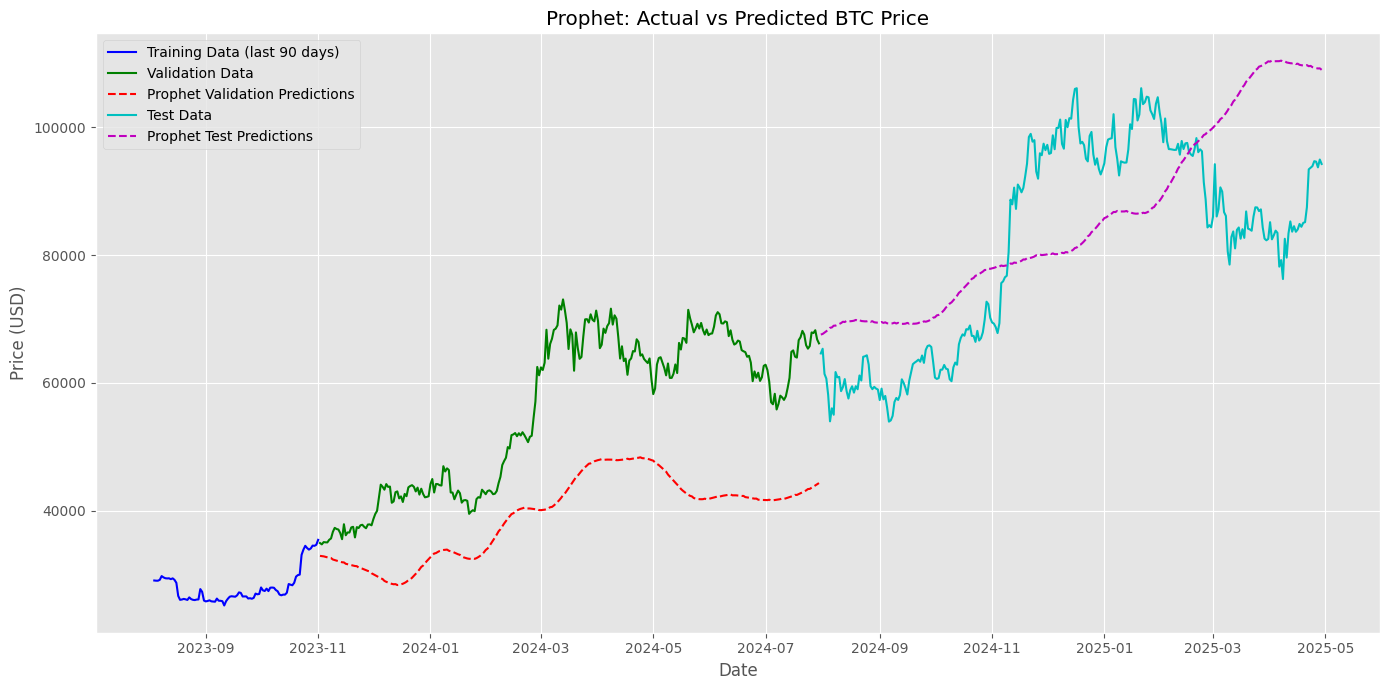

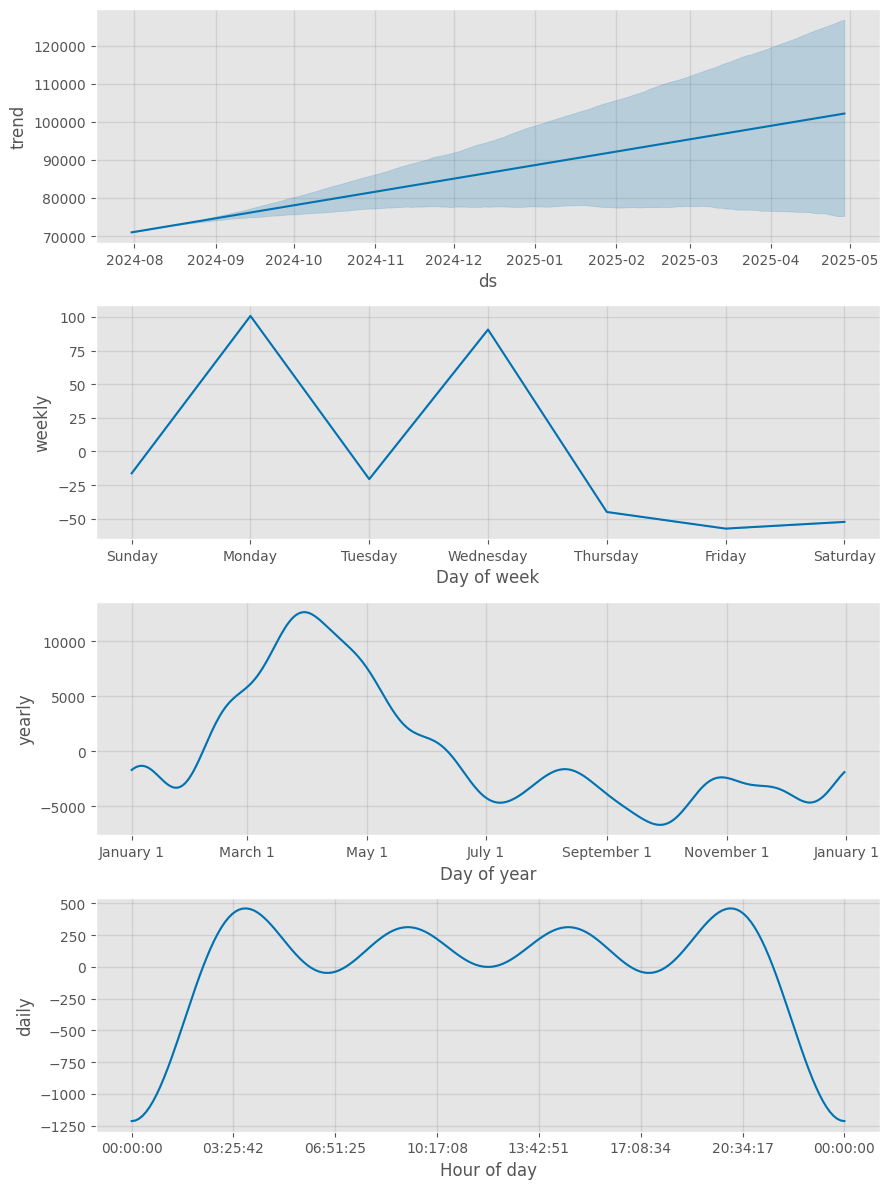

In [39]:
print("Preparing data for Prophet...")

try:
    # Prepare training data for Prophet
    prophet_train = pd.DataFrame({
        'ds': y_train.index,
        'y': y_train.values.flatten()
    })
    
    # Prepare validation dates
    val_dates = pd.DataFrame({'ds': y_val.index})
    
    # Prepare test dates
    test_dates = pd.DataFrame({'ds': y_test.index})
    
    # Train Prophet model on training data
    prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet_model.fit(prophet_train)
    
    # Forecast for validation set
    val_forecast = prophet_model.predict(val_dates)
    prophet_val_preds = pd.Series(
        val_forecast['yhat'].values,
        index=y_val.index
    )
    
    # Calculate validation metrics
    prophet_val_metrics = calculate_metrics(y_val, prophet_val_preds)
    print("\n📈 Prophet Model Validation Metrics:")
    for key, value in prophet_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain on train + validation data
    prophet_train_val = pd.DataFrame({
        'ds': pd.concat([y_train, y_val]).index,
        'y': pd.concat([y_train, y_val]).values.flatten()
    })
    
    prophet_model_final = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet_model_final.fit(prophet_train_val)
    
    # Forecast for test set
    test_forecast = prophet_model_final.predict(test_dates)
    prophet_test_preds = pd.Series(
        test_forecast['yhat'].values,
        index=y_test.index
    )
    
    # Calculate test metrics
    prophet_test_metrics = calculate_metrics(y_test, prophet_test_preds)
    print("\n📈 Prophet Model Test Metrics:")
    for key, value in prophet_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
    plt.plot(prophet_val_preds.index, prophet_val_preds, 'r--', label='Prophet Validation Predictions')
    # Plot test data
    plt.plot(y_test.index, y_test, 'c-', label='Test Data')
    plt.plot(prophet_test_preds.index, prophet_test_preds, 'm--', label='Prophet Test Predictions')
    
    plt.title('Prophet: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot Prophet Components (using final model)
    fig = prophet_model_final.plot_components(test_forecast)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in Prophet modeling: {e}")
    traceback.print_exc()

#### Machine Learning Models

##### Random Forest

Training Random Forest model...

Random Forest Validation Metrics:
MAE: 2002.3356
RMSE: 2771.4015
MAPE: 3.3241
Directional Accuracy (%): 48.3395
R2: 0.9474

Random Forest Test Metrics:
MAE: 15341.9304
RMSE: 19558.9931
MAPE: 16.4909
Directional Accuracy (%): 50.0000
R2: -0.5112


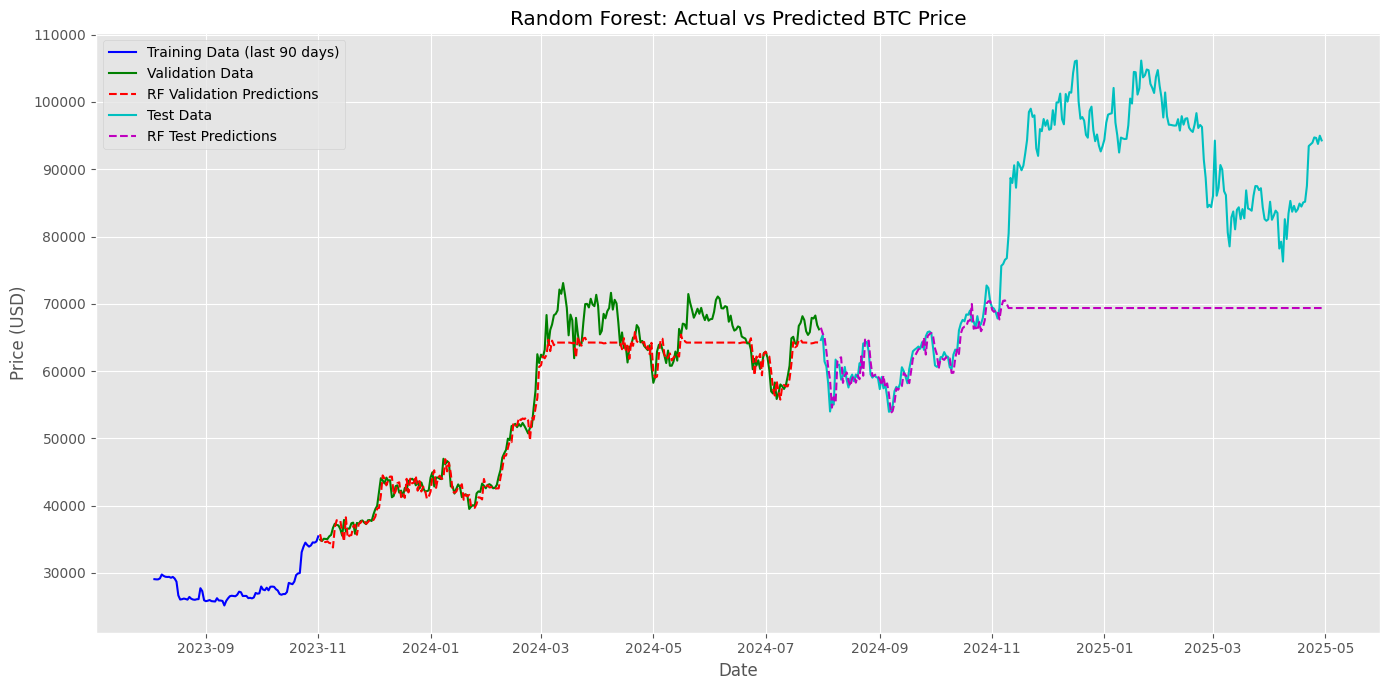

In [40]:
print("Training Random Forest model...")

try:
    # Train Random Forest on training data
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predict on validation set
    rf_val_preds = rf_model.predict(X_val)
    rf_val_preds_series = pd.Series(rf_val_preds, index=y_val.index)
    
    # Calculate validation metrics
    rf_val_metrics = calculate_metrics(y_val, rf_val_preds_series)
    print("\nRandom Forest Validation Metrics:")
    for key, value in rf_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain on train + validation data
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    rf_model_final = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model_final.fit(X_train_val, y_train_val)
    
    # Predict on test set
    rf_test_preds = rf_model_final.predict(X_test)
    rf_test_preds_series = pd.Series(rf_test_preds, index=y_test.index)
    
    # Calculate test metrics
    rf_test_metrics = calculate_metrics(y_test, rf_test_preds_series)
    print("\nRandom Forest Test Metrics:")
    for key, value in rf_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
    plt.plot(rf_val_preds_series.index, rf_val_preds_series, 'r--', label='RF Validation Predictions')
    # Plot test data
    plt.plot(y_test.index, y_test, 'c-', label='Test Data')
    plt.plot(rf_test_preds_series.index, rf_test_preds_series, 'm--', label='RF Test Predictions')
    
    plt.title('Random Forest: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in Random Forest modeling: {e}")
    traceback.print_exc()

##### XGBOOST


Training XGBoost model...

XGBoost Validation Metrics:
MAE: 2215.7201
RMSE: 3119.6145
MAPE: 3.5899
Directional Accuracy (%): 49.4465
R2: 0.9333

XGBoost Test Metrics:
MAE: 15534.1071
RMSE: 19811.5816
MAPE: 16.6910
Directional Accuracy (%): 50.0000
R2: -0.5505


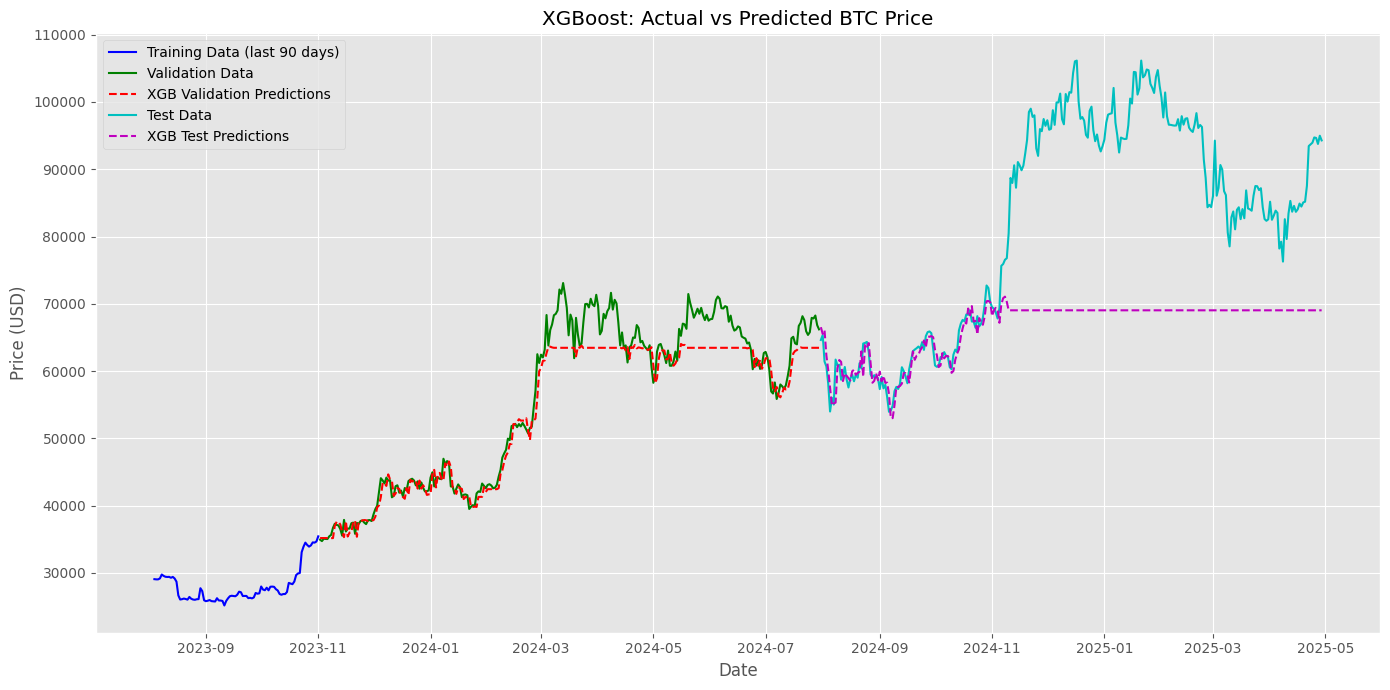

In [41]:
print("\nTraining XGBoost model...")

try:
    # Train XGBoost on training data
    # XGBoost with regularization
    xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05, 
    max_depth=3, 
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  
    reg_lambda=1.0,  
    random_state=42,
    n_jobs=-1
)
    
    xgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    xgb_val_preds = xgb_model.predict(X_val)
    xgb_val_preds_series = pd.Series(xgb_val_preds, index=y_val.index)
    
    # Calculate validation metrics
    xgb_val_metrics = calculate_metrics(y_val, xgb_val_preds_series)
    print("\nXGBoost Validation Metrics:")
    for key, value in xgb_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain on train + validation data
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    xgb_model_final = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model_final.fit(X_train_val, y_train_val)
    
    # Predict on test set
    xgb_test_preds = xgb_model_final.predict(X_test)
    xgb_test_preds_series = pd.Series(xgb_test_preds, index=y_test.index)
    
    # Calculate test metrics
    xgb_test_metrics = calculate_metrics(y_test, xgb_test_preds_series)
    print("\nXGBoost Test Metrics:")
    for key, value in xgb_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
    plt.plot(xgb_val_preds_series.index, xgb_val_preds_series, 'r--', label='XGB Validation Predictions')
    # Plot test data
    plt.plot(y_test.index, y_test, 'c-', label='Test Data')
    plt.plot(xgb_test_preds_series.index, xgb_test_preds_series, 'm--', label='XGB Test Predictions')
    
    plt.title('XGBoost: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in XGBoost modeling: {e}")
    traceback.print_exc()

#### LSTM


Preparing data for LSTM model...
LSTM input shapes - Train: (1271, 1, 5), Val: (272, 1, 5), Test: (273, 1, 5)
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1921 - val_loss: 0.5516
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1270 - val_loss: 0.2385
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0192
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0099
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0102
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0092
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0074
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0053
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0090
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0050
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━

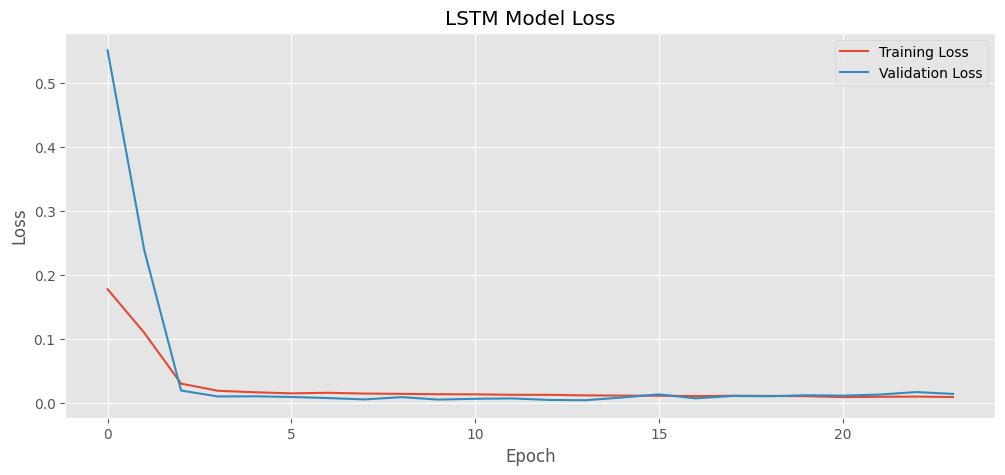

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

LSTM Validation Metrics:
MAE: 2124.5550
RMSE: 2734.2661
MAPE: 3.5828
Directional Accuracy (%): 49.0775
R2: 0.9488
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1970 - val_loss: 0.7706
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1400 - val_loss: 0.2287
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278 - val_loss: 0.0284
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.0154
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0076
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0072
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0044
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.0

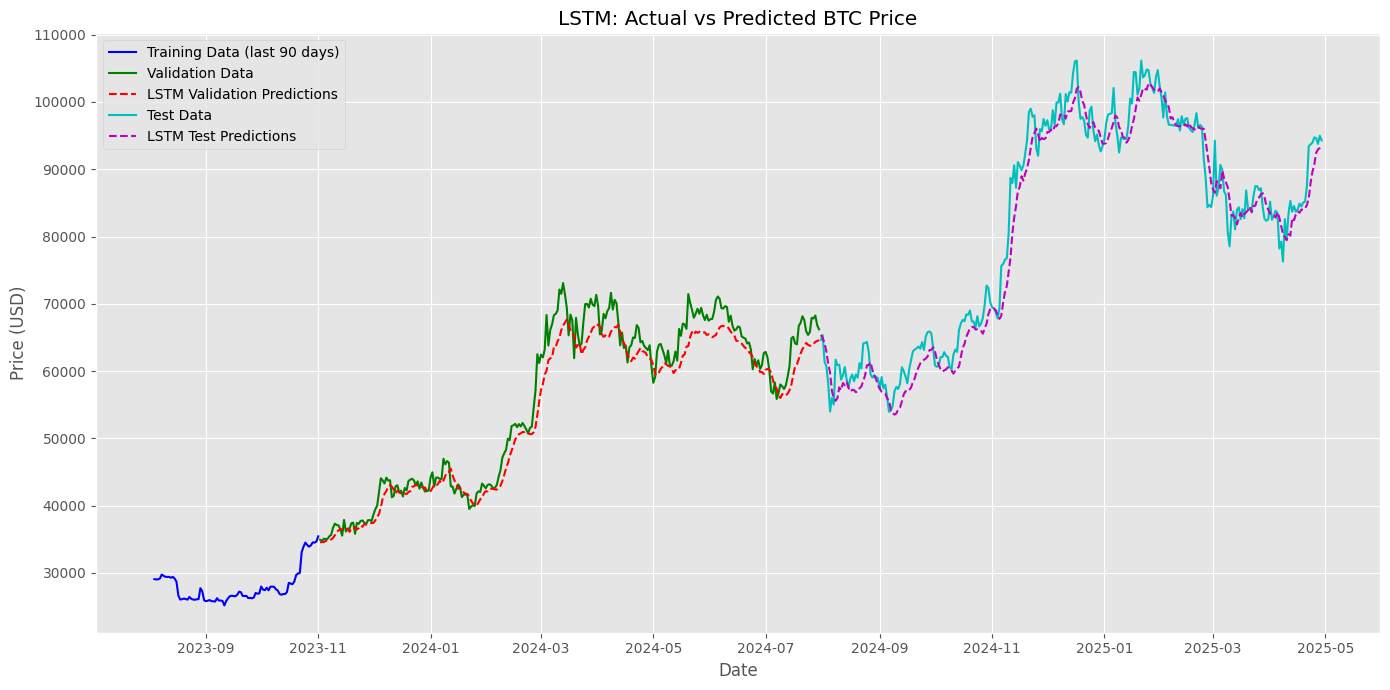

In [42]:
print("\nPreparing data for LSTM model...")

try:
    # Reshape the data for LSTM [samples, timesteps, features]
    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_lstm = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Print shapes for debugging
    print(f"LSTM input shapes - Train: {X_train_lstm.shape}, Val: {X_val_lstm.shape}, Test: {X_test_lstm.shape}")
    
    # Build LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, return_sequences=True, dropout=0.2),
        LSTM(16, dropout=0.2),
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train_lstm, y_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_lstm, y_val_scaled),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Loss Plot
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Predict on validation set
    lstm_val_preds_scaled = model.predict(X_val_lstm)
    lstm_val_preds = y_scaler.inverse_transform(lstm_val_preds_scaled)
    lstm_val_preds_series = pd.Series(lstm_val_preds.flatten(), index=y_val.index)
    
    # Calculate validation metrics
    lstm_val_metrics = calculate_metrics(y_val, lstm_val_preds_series)
    print("\nLSTM Validation Metrics:")
    for key, value in lstm_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain model on train + validation data
    X_train_val_lstm = np.concatenate([X_train_lstm, X_val_lstm])
    y_train_val_scaled = np.concatenate([y_train_scaled, y_val_scaled])
    
    model_final = Sequential([
        LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, return_sequences=True, dropout=0.2),
        LSTM(16, dropout=0.2),
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
    model_final.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    
    history_final = model_final.fit(
        X_train_val_lstm, y_train_val_scaled,
        epochs=100,
        batch_size=32,
        validation_split=0.1,  # Small validation to monitor
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Predict on test set
    lstm_test_preds_scaled = model_final.predict(X_test_lstm)
    lstm_test_preds = y_scaler.inverse_transform(lstm_test_preds_scaled)
    lstm_test_preds_series = pd.Series(lstm_test_preds.flatten(), index=y_test.index)
    
    # Calculate test metrics
    lstm_test_metrics = calculate_metrics(y_test, lstm_test_preds_series)
    print("\nLSTM Test Metrics:")
    for key, value in lstm_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
    plt.plot(lstm_val_preds_series.index, lstm_val_preds_series, 'r--', label='LSTM Validation Predictions')
    # Plot test data
    plt.plot(y_test.index, y_test, 'c-', label='Test Data')
    plt.plot(lstm_test_preds_series.index, lstm_test_preds_series, 'm--', label='LSTM Test Predictions')
    
    plt.title('LSTM: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in LSTM modeling: {e}")
    traceback.print_exc()


Preparing data for GRU model...
GRU input shapes - Train: (1271, 1, 5), Val: (272, 1, 5), Test: (273, 1, 5)
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1504 - val_loss: 0.1506
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - val_loss: 0.0561
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - val_loss: 0.0218
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0089
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0112
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0086
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0077
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0087
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0091
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0076
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━

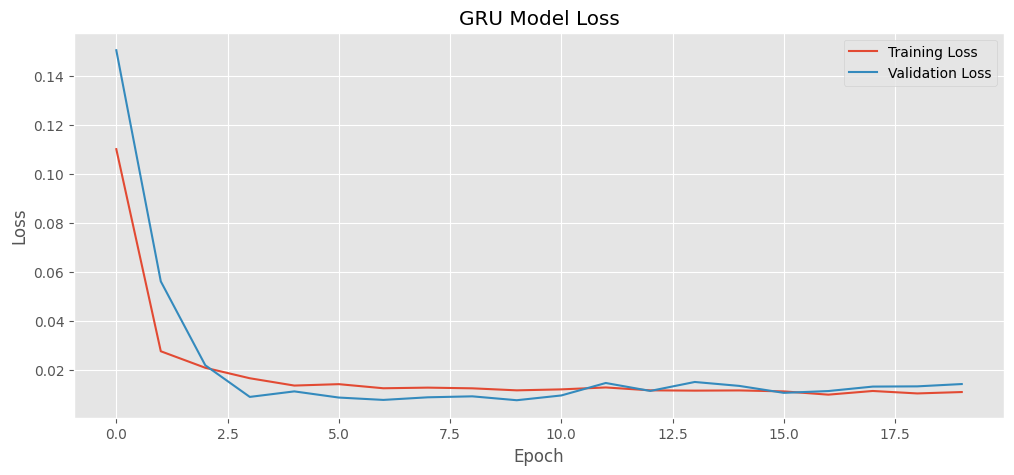

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

GRU Validation Metrics:
MAE: 3493.5692
RMSE: 4378.6842
MAPE: 5.6606
Directional Accuracy (%): 47.6015
R2: 0.8686
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1434 - val_loss: 0.1362
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - val_loss: 0.0663
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.0234
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0112
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0129
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0156
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0125
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0090
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0139
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.01

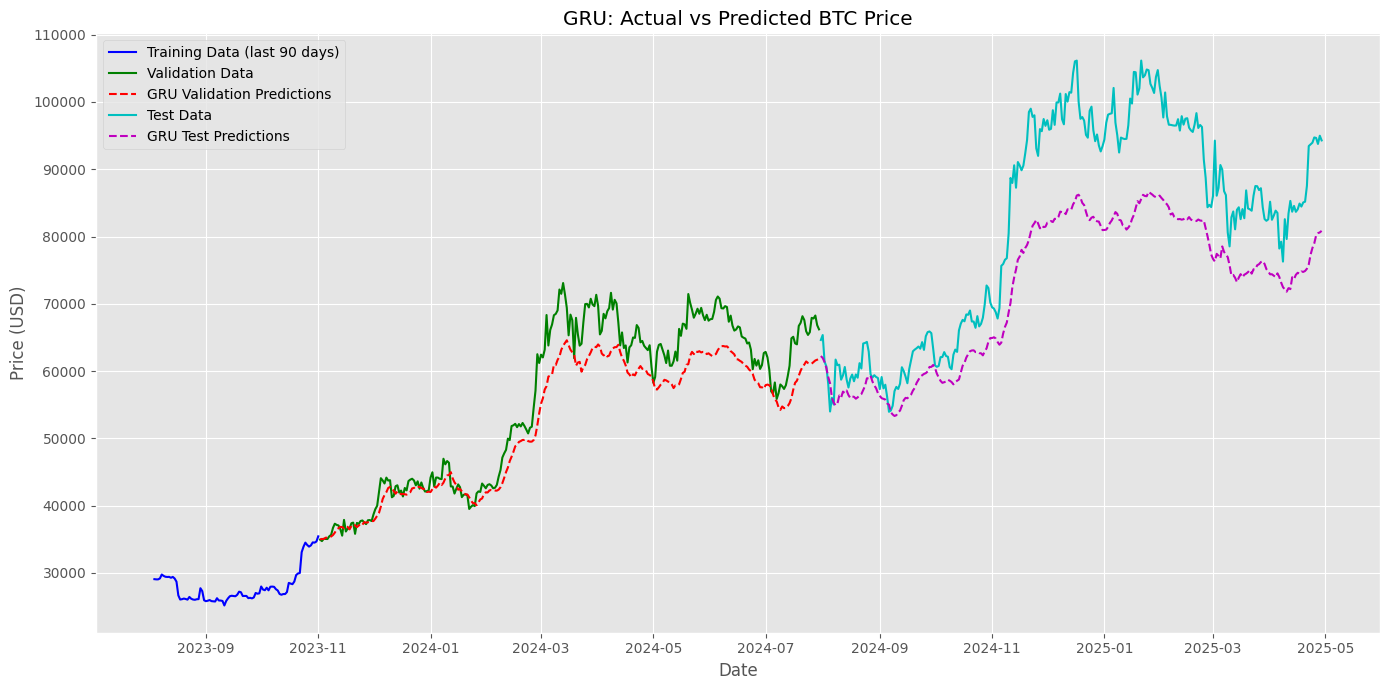


Model Performance Comparison:
Metric		LSTM Test	GRU Test
MAE		2392.2757		9709.4488
RMSE		3053.1412		11142.9090
MAPE		3.0270		11.0306
Directional Accuracy (%)		52.9412		51.8382
R2		0.9632		0.5095


In [43]:
print("\nPreparing data for GRU model...")

try:
    # Reshape the data for GRU [samples, timesteps, features]
    X_train_gru = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_gru = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test_gru = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Print shapes for debugging
    print(f"GRU input shapes - Train: {X_train_gru.shape}, Val: {X_val_gru.shape}, Test: {X_test_gru.shape}")
    
    # Build GRU model
    gru_model = Sequential([
        GRU(64, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.2, recurrent_dropout=0.2),
        GRU(32, return_sequences=True, dropout=0.2),
        GRU(16, dropout=0.2),
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
    gru_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    gru_history = gru_model.fit(
        X_train_gru, y_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_gru, y_val_scaled),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Loss Plot
    plt.figure(figsize=(12, 5))
    plt.plot(gru_history.history['loss'], label='Training Loss')
    plt.plot(gru_history.history['val_loss'], label='Validation Loss')
    plt.title('GRU Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Predict on validation set
    gru_val_preds_scaled = gru_model.predict(X_val_gru)
    gru_val_preds = y_scaler.inverse_transform(gru_val_preds_scaled)
    gru_val_preds_series = pd.Series(gru_val_preds.flatten(), index=y_val.index)
    
    # Calculate validation metrics
    gru_val_metrics = calculate_metrics(y_val, gru_val_preds_series)
    print("\nGRU Validation Metrics:")
    for key, value in gru_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Retrain model on train + validation data
    X_train_val_gru = np.concatenate([X_train_gru, X_val_gru])
    y_train_val_scaled = np.concatenate([y_train_scaled, y_val_scaled])
    
    gru_model_final = Sequential([
        GRU(64, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.2, recurrent_dropout=0.2),
        GRU(32, return_sequences=True, dropout=0.2),
        GRU(16, dropout=0.2),
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
    gru_model_final.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    
    gru_history_final = gru_model_final.fit(
        X_train_val_gru, y_train_val_scaled,
        epochs=100,
        batch_size=32,
        validation_split=0.1,  # Small validation to monitor
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Predict on test set
    gru_test_preds_scaled = gru_model_final.predict(X_test_gru)
    gru_test_preds = y_scaler.inverse_transform(gru_test_preds_scaled)
    gru_test_preds_series = pd.Series(gru_test_preds.flatten(), index=y_test.index)
    
    # Calculate test metrics
    gru_test_metrics = calculate_metrics(y_test, gru_test_preds_series)
    print("\nGRU Test Metrics:")
    for key, value in gru_test_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    # Plot training data (last 90 days)
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    # Plot validation data
    plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
    plt.plot(gru_val_preds_series.index, gru_val_preds_series, 'r--', label='GRU Validation Predictions')
    # Plot test data
    plt.plot(y_test.index, y_test, 'c-', label='Test Data')
    plt.plot(gru_test_preds_series.index, gru_test_preds_series, 'm--', label='GRU Test Predictions')
    
    plt.title('GRU: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Compare LSTM and GRU performance
    print("\nModel Performance Comparison:")
    print("Metric\t\tLSTM Test\tGRU Test")
    for key in lstm_test_metrics.keys():
        print(f"{key}\t\t{lstm_test_metrics[key]:.4f}\t\t{gru_test_metrics[key]:.4f}")
    
except Exception as e:
    print(f"Error in GRU modeling: {e}")
    traceback.print_exc()

#### Conclusion


Validation Metrics Comparison:


MAE          RMSE       MAPE  \
Model                                                  
ARIMA          20153.890912  23482.926516  32.811079   
Prophet        16281.326810  17771.843841  27.965847   
Random Forest   2002.335600   2771.401457   3.324091   
XGBoost         2215.720129   3119.614503   3.589920   
LSTM            2124.555018   2734.266093   3.582796   
GRU             3493.569221   4378.684193   5.660587   

               Directional Accuracy (%)        R2  
Model                                              
ARIMA                         47.232472 -2.777978  
Prophet                       52.767528 -1.163814  
Random Forest                 48.339483  0.947380  
XGBoost                       49.446494  0.933326  
LSTM                          49.077491  0.948780  
GRU                           47.601476  0.868646


Test Metrics Comparison:


MAE          RMSE       MAPE  \
Model                                                  
ARIMA          18662.272774  22212.050094  20.888084   
Prophet        13061.584975  14855.863450  16.137093   
Random Forest  15341.930380  19558.993120  16.490947   
XGBoost        15534.107071  19811.581581  16.691048   
LSTM            2392.275741   3053.141220   3.027018   
GRU             9709.448804  11142.908956  11.030614   

               Directional Accuracy (%)        R2  
Model                                              
ARIMA                         48.529412 -0.948988  
Prophet                       50.735294  0.128178  
Random Forest                 50.000000 -0.511210  
XGBoost                       50.000000 -0.550494  
LSTM                          52.941176  0.963176  
GRU                           51.838235  0.509511

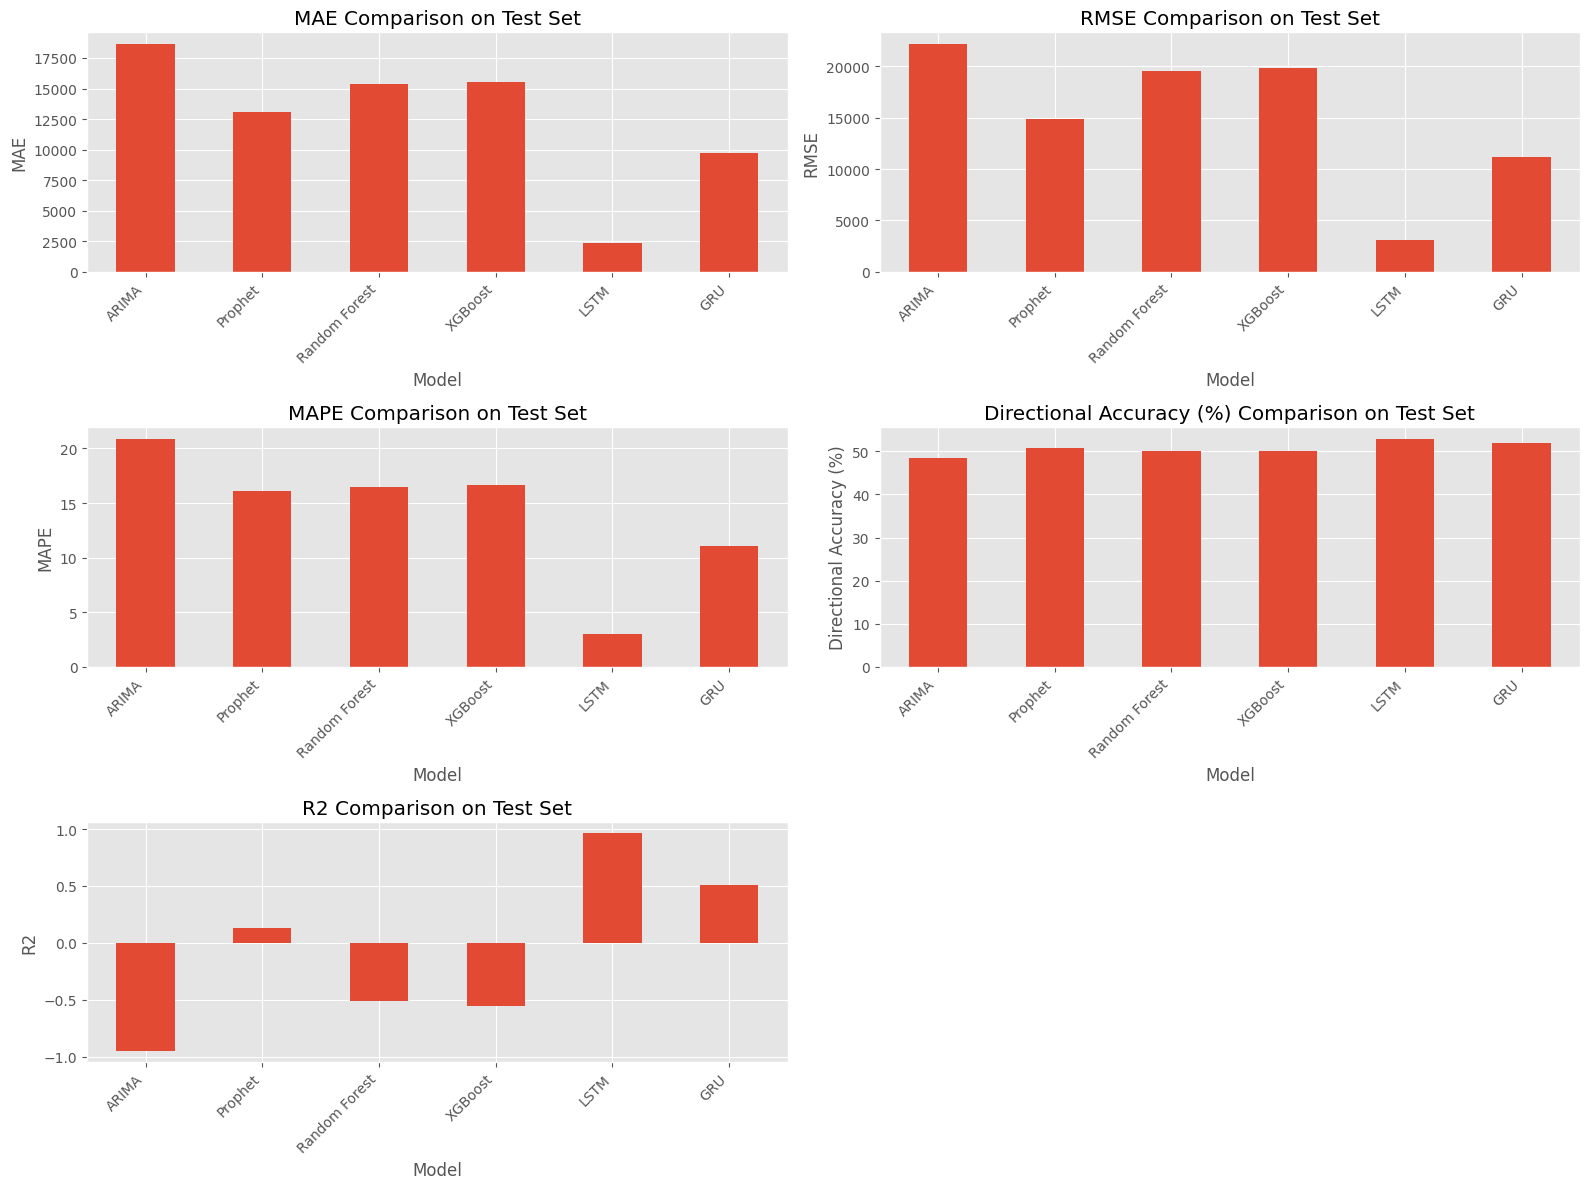

In [44]:
# Collect all metrics into a DataFrame for comparison
model_names = ['ARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM', 'GRU']

# Test metrics
test_metrics = [arima_test_metrics, prophet_test_metrics, rf_test_metrics, xgb_test_metrics, lstm_test_metrics, gru_test_metrics]
test_metrics_df = pd.DataFrame(test_metrics, index=model_names)
test_metrics_df.index.name = 'Model'

# Validation metrics
val_metrics = [arima_val_metrics, prophet_val_metrics, rf_val_metrics, xgb_val_metrics, lstm_val_metrics, gru_val_metrics]
val_metrics_df = pd.DataFrame(val_metrics, index=model_names)
val_metrics_df.index.name = 'Model'

# Display the comparison
print("\nValidation Metrics Comparison:")
display(val_metrics_df)

print("\nTest Metrics Comparison:")
display(test_metrics_df)

# Create bar plots to visualize test performance
plt.figure(figsize=(16, 12))

# Plot for each metric
metrics = ['MAE', 'RMSE', 'MAPE', 'Directional Accuracy (%)', 'R2']
for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    # Add the plotting command here
    test_metrics_df[metric].plot(kind='bar', ax=plt.gca()) # Use plot(kind='bar') on the DataFrame column
    plt.title(f'{metric} Comparison on Test Set')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

# Add tight_layout and show after the loop
plt.tight_layout()
plt.show()